# Modeling Assignment Group_10

##  Submitted by: Raunak Sharma,Hunter Harmer,McKay Flake

### Table of Contents

1. [Introduction](#Introduction)
   - [Analysis Questions](#Analysis-Questions)
2. [Data Overview and Initial Exploration](#Data-Overview-and-Initial-Exploration)
   - [Data Description](#Data-Description)
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis)     
   - [Data Visualization](#Data-Visualization)
   - [Initial Analysis and Feature Engineering](#Initial-Analysis-and-Feature-Engineering)
   - [Initial Data Preprocessing](#Initial-Data-Preprocessing)
   - [Model Development and Evaluation](#Model-Development-and-Evaluation)
   - [Initial Model Selection and Training](#Initial-Model-Selection-and-Training)
   - [Initial Model Evaluation](#Initial-Model-Evaluation)
   - [Hyperparameter Tuning](#Hyperparameter-Tuning)
   - [Final Analysis](#Final-Analysis)
   - [Handling Missing Data](#Handling-Missing-Data)
   - [Final Model Training and Evaluation](#Final-Model-Training-and-Evaluation)
   - [Final Feature Engineering](#Final-Feature-Engineering)
   - [Linear Regression](#Linear-Regression)
   - [Random Forest Model](#Random-Forest-Model)
   - [Modified XGBoost](#Modified-XGBoost)
   - [Cross-Validation and Performance Metrics](#Cross-Validation-and-Metrics)     
4. [Results and Summary](#Results-and-Summary)
   - [Modeling Results Summary](#Modeling-Results-Summary)
   - [Performance Metrics and Summary Table](#Performance-Metrics-and-Summary-Table)   
5. [Alternative Approach: Classification Model](#Alternative-Approach-Classification-Model)
   - [Introduction](#Alternative-Introduction)
   - [Data Preparation](#Alternative-Data-Preparation)
   - [Modeling Process](#Alternative-Modeling-Process)
   - [Key Metrics](#Alternative-Key-Metrics)
   - [Results](#Alternative-Results)
6. [Questions And Answers](#Questions-And-Answers)  
7. [Recommendations](#Recommendations)
8. [Group member contributions](#Group-member-contributions)

## Introduction <a id="Introduction"></a>

### Objective
This project aims to provide Swire Coca-Cola with a predictive maintenance framework that may help minimize unplanned machine downtimes, improve productivity, and reduce financial losses across their production plants. Focusing on ACTUAL_WORK_IN_MINUTES (downtime), which represents machine downtime duration, the analysis will seek to predict maintenance needs and inform preventive measures. Additionally, a classification component will assess whether upcoming maintenance is likely to be planned or unplanned, enabling early identification of high-risk events. Together, these models aim to support Swire Coca-Cola in proactively addressing machine failures, optimizing resource allocation, and enhancing operational efficiency across plants.

### Business and Analytic Problems
Unplanned downtimes create significant disruptions, leading to operational delays and financial strain. From a business perspective, the primary challenge is identifying predictors of machine breakdowns—such as maintenance activity type (planned or unplanned), frequently problematic equipment, and specific locations with high downtime. Analytically, this requires identifying factors that contribute to both downtime duration and the likelihood of unplanned maintenance. With these insights, we aim to build a predictive model that addresses downtime while enabling Swire Coca-Cola to plan and allocate resources efficiently.

### Approach and Model Selection
Our analysis will follow a comprehensive approach to data preparation, feature engineering, and model development. Data cleaning and transformation steps will address missing values, high-cardinality variables, and date features, creating a robust dataset for analysis. Initial exploratory data analysis (EDA) will reveal patterns within predictors like EQUIPMENT_ID, MAINTENANCE_TYPE, and functional location, guiding feature selection and model design. We will test regression models, including Linear Regression, Random Forest, and XGBoost, to predict downtime duration, alongside a classification model to identify planned versus unplanned maintenance. Through cross-validation, we will evaluate model performance for reliability, and further optimize the top-performing model by minimizing mean squared error (MSE) and maximizing R².

### Performance and Operational Efficiency
Reducing unplanned downtimes has the potential to lessen operational disruptions and improve resource use. Following model evaluation, we will estimate potential cost savings and operational efficiency gains that may result from applying these predictive models. This approach aims to give Swire Coca-Cola an actionable, data-driven strategy for enhancing production continuity and resilience across facilities. Through predictive insights into downtime and maintenance type, Swire Coca-Cola may gain measurable improvements in operational efficiency and targeted maintenance planning.

### Analysis Questions <a id="Analysis-Questions"></a>

1. Identify a performance benchmark. What is a minimum threshold for model performance?
2. Identify appropriate models to explore.
3. Do additional data preparation and feature engineering as necessary.
4. Perform cross-validation to develop performance metrics for each model, appropriate for the context.
5. Optimize model performance with hyperparameter tuning, if appropriate.
6. Evaluate the strengths and weaknesses of each model and select the best one.
7. Perform business validation of the model. Are your results sufficient to solve the business problem?

## Data Overview and Initial Exploration <a id="Data-Overview-and-Initial-Exploration"></a>

### Load Libraries and Dataset

In [1]:
%%capture
!pip install optuna

In [32]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

In [92]:
from sklearn.preprocessing import LabelEncoder

In [5]:
# Load the dataset with low_memory=False to reduce dtype warnings
file_path = 'IWC_Work_Orders_Extract.csv'
data = pd.read_csv(file_path, low_memory=False)

# Cap the target variable at the 95th percentile to handle outliers
y = data['ACTUAL_WORK_IN_MINUTES']
cap_value = y.quantile(0.95)
data['ACTUAL_WORK_IN_MINUTES'] = y.clip(upper=cap_value)


### Inspecting the dataset

In [293]:
df = pd.read_csv('IWC_Work_Orders_Extract.csv', low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427264 entries, 0 to 1427263
Data columns (total 25 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   ORDER_ID                         1427264 non-null  int64  
 1   PLANT_ID                         1427264 non-null  object 
 2   PRODUCTION_LOCATION              1427264 non-null  object 
 3   EXECUTION_START_DATE             1427264 non-null  object 
 4   EXECUTION_FINISH_DATE            1427264 non-null  object 
 5   ACTUAL_START_TIME                1427264 non-null  object 
 6   ACTUAL_FINISH_TIME               1427264 non-null  object 
 7   ACTUAL_WORK_IN_MINUTES           1427264 non-null  float64
 8   MAINTENANCE_PLAN                 152594 non-null   object 
 9   MAINTENANCE_ITEM                 152594 non-null   float64
 10  MAINTENANCE_ACTIVITY_TYPE        1427264 non-null  object 
 11  ORDER_DESCRIPTION                291767 non-null  

*The dataset consists of 1,427,264 entries and 25 columns, with a mix of data types (categorical, numerical, and datetime). Critical operational columns such as ORDER_ID, ACTUAL_WORK_IN_MINUTES, and MAINTENANCE_ACTIVITY_TYPE are complete, but several columns related to maintenance and equipment, like EQUIPMENT_DESC and MAINTENANCE_ITEM, have significant missing data. The majority of columns are object types, indicating categorical data or date fields that may need parsing for further analysis.*

In [295]:
#summary statistics
df.describe(include='all')

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,...,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO
count,1.427264e+06,1427264,1427264,1427264,1427264,1427264,1427264,1.427264e+06,152594,152594.000000,...,282407,258691,237573,2180,2.917950e+05,79447,79447,79447,79447,79447
unique,NaN,6,6,2956,2956,65927,61388,NaN,3308,NaN,...,67,141,86,36,NaN,807,4,92,137,1
top,NaN,G261,SILVERSTONE,2019-04-16,2019-04-16,00:00:00.000,00:00:00.000,NaN,000000022943,NaN,...,CAN LINE,LINE #4-FILLER_ROTARY_CAN,FILLER,FULL CAN TO ACCUMULATION TABLE,NaN,L1 FILLER_ROTARY_CAN_72_VALVE,Machines,2017-02-15,2017-02-15,9999-12-31
freq,NaN,630903,630903,936,934,212155,202920,NaN,1327,NaN,...,34208,35834,46322,251,NaN,3745,79224,53650,32713,79447
mean,4.561470e+10,NaN,NaN,NaN,NaN,NaN,NaN,8.862968e+01,NaN,115846.807954,...,NaN,NaN,NaN,NaN,3.002609e+08,NaN,NaN,NaN,NaN,NaN
std,8.387114e+10,NaN,NaN,NaN,NaN,NaN,NaN,8.037915e+02,NaN,71325.255687,...,NaN,NaN,NaN,NaN,5.581645e+06,NaN,NaN,NaN,NaN,NaN
min,1.000219e+08,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,39801.000000,...,NaN,NaN,NaN,NaN,2.000871e+08,NaN,NaN,NaN,NaN,NaN
25%,4.022602e+08,NaN,NaN,NaN,NaN,NaN,NaN,1.200000e+01,NaN,41046.000000,...,NaN,NaN,NaN,NaN,3.000092e+08,NaN,NaN,NaN,NaN,NaN
50%,7.044271e+08,NaN,NaN,NaN,NaN,NaN,NaN,4.800000e+01,NaN,112995.000000,...,NaN,NaN,NaN,NaN,3.000178e+08,NaN,NaN,NaN,NaN,NaN
75%,1.002343e+09,NaN,NaN,NaN,NaN,NaN,NaN,9.000000e+01,NaN,134702.000000,...,NaN,NaN,NaN,NaN,3.000269e+08,NaN,NaN,NaN,NaN,NaN


### Data Description <a id="Data-Description"></a>

*The data provided for this project comes from Swire Coca-Cola's internal system, IWC, which tracks equipment breakdowns. The dataset contains maintenance records with key features such as plant ID, equipment ID, execution date, work duration, and type of maintenance. It is a large dataset with over 1.4 million records. The case description notes that the "actual working minutes" is the most reliable variable for determining the time spent on repairs, as the "actual start time" and "actual end time" can be inaccurate in certain situations.*

## Exploratory Data Analysis <a id="Exploratory-Data-Analysis"></a>

## Data Visualization <a id="Data-Visualization"></a>

### Unplanned Maintenance by Machine Age

**Whether older machines are more likely to experience unplanned maintenance**

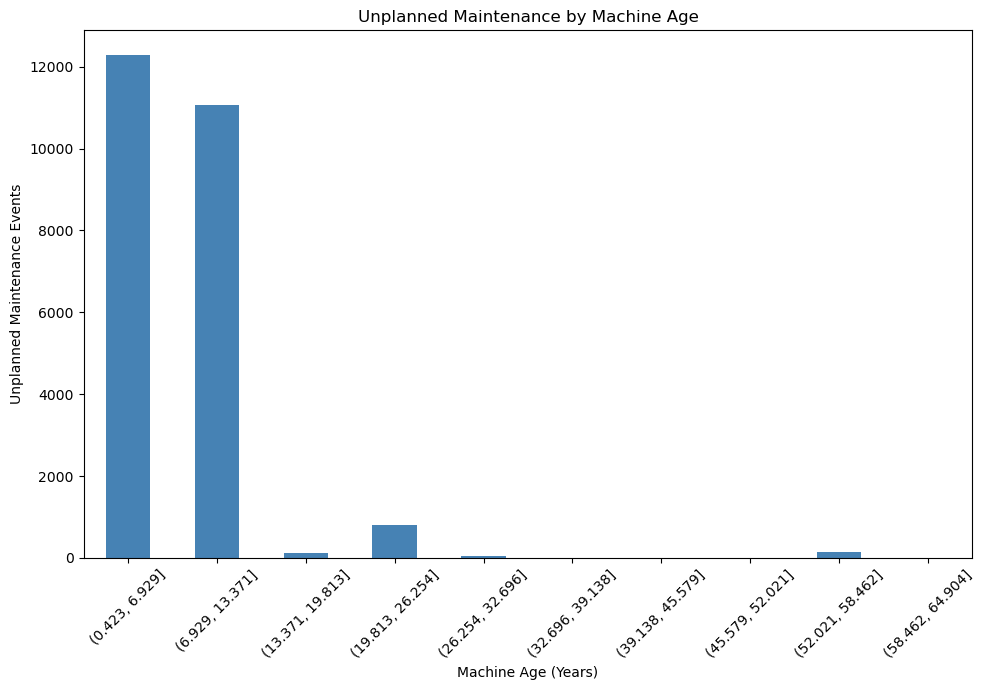

In [297]:
# Create a copy for this specific analysis
df_copy1 = df.copy()

# Convert EQUIP_START_UP_DATE to datetime and calculate machine age in years
df_copy1['EQUIP_START_UP_DATE'] = pd.to_datetime(df_copy1['EQUIP_START_UP_DATE'], errors='coerce')
df_copy1['MACHINE_AGE_YEARS'] = (pd.Timestamp.now() - df_copy1['EQUIP_START_UP_DATE']).dt.days / 365

# Filter for unplanned maintenance events and group by machine age bins
unplanned = df_copy1[df_copy1['MAINTENANCE_ACTIVITY_TYPE'] == 'Unplanned']
age_bins = pd.cut(unplanned['MACHINE_AGE_YEARS'], bins=10)
unplanned_by_age = unplanned.groupby(age_bins, observed=False).size()  # Set observed=False

# Plot the data
plt.figure(figsize=(10, 7))
unplanned_by_age.plot(kind='bar', color='steelblue')
plt.title('Unplanned Maintenance by Machine Age')
plt.xlabel('Machine Age (Years)')
plt.ylabel('Unplanned Maintenance Events')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


*The above bar chart and summary table shows that younger machines (0.3 to 6 years old) experience more unplanned maintenance than older ones. This suggests that predictive maintenance efforts might be more effective if focused on older machines with established maintenance protocols.*

### Functional locations that experience the highest downtime

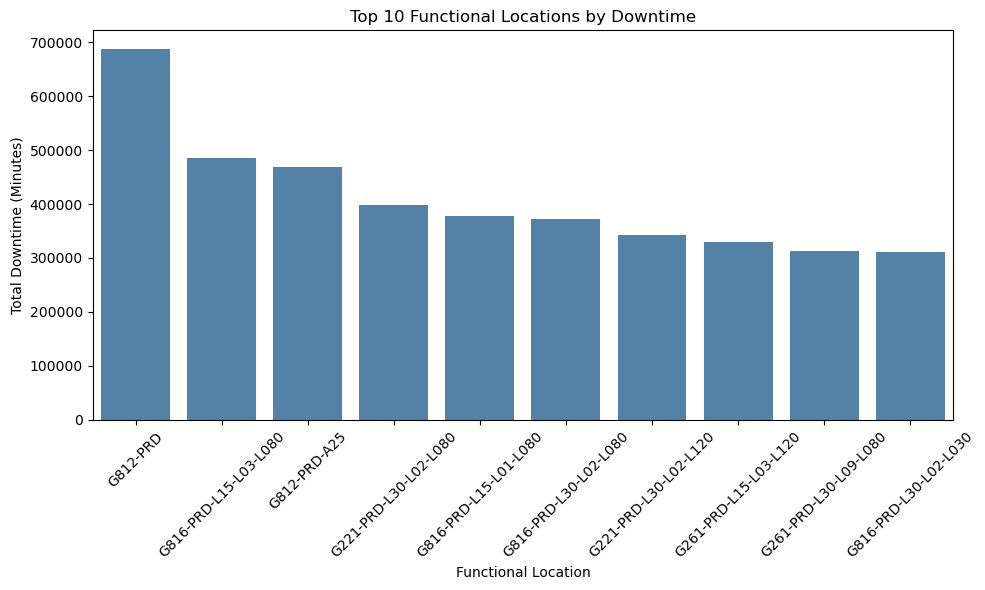

In [305]:
# Top 10 Functional Locations by Downtime using steelblue color palette
downtime_by_functional_loc = df.groupby('FUNCTIONAL_LOC')['ACTUAL_WORK_IN_MINUTES'].sum().reset_index()
downtime_by_functional_loc_sorted = downtime_by_functional_loc.sort_values('ACTUAL_WORK_IN_MINUTES', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='FUNCTIONAL_LOC', y='ACTUAL_WORK_IN_MINUTES', data=downtime_by_functional_loc_sorted.head(10), color='steelblue')
plt.title('Top 10 Functional Locations by Downtime')
plt.xlabel('Functional Location')
plt.ylabel('Total Downtime (Minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*The bar chart shows the Top 10 Functional Locations by downtime, with G812-PRD having the highest total downtime, exceeding 700,000 minutes. Several other locations, such as G816-PRD-L15-103-1080 and G812-PRD-A25, also have significant downtimes, but none come close to G812-PRD. The distribution indicates that specific locations have much higher downtime, which may warrant further investigation into their maintenance processes or equipment issues.*

### Distribution of Downtime and Box Plot

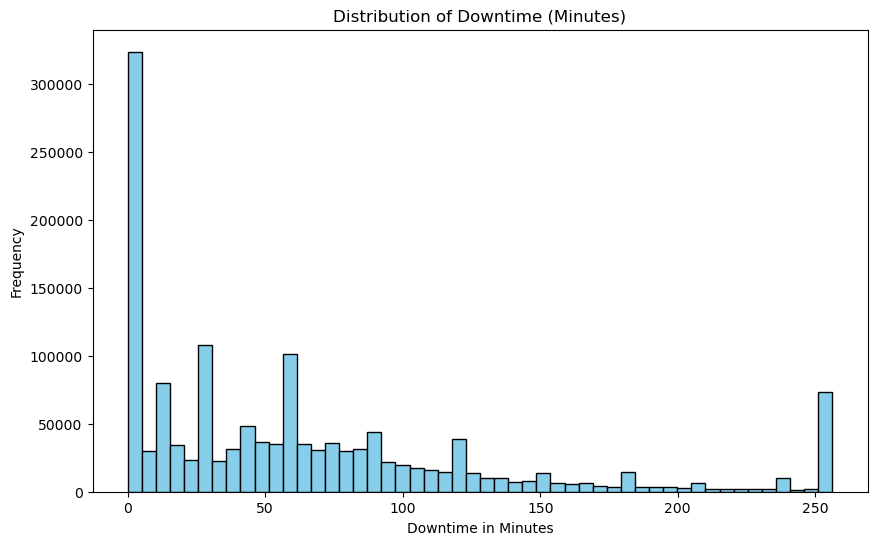

In [38]:
# Histogram of downtime
plt.figure(figsize=(10, 6))
plt.hist(data['ACTUAL_WORK_IN_MINUTES'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Downtime (Minutes)')
plt.xlabel('Downtime in Minutes')
plt.ylabel('Frequency')
plt.savefig("Downtime in Minutes histrogram.png", format="png", dpi=300, bbox_inches="tight")
plt.show()


*The histogram shows the distribution of downtime in minutes, revealing a highly skewed pattern. Most downtime events are short, with a large peak near zero, indicating that the majority of downtime durations are brief. There are some periodic peaks across the distribution, suggesting possible common intervals or specific maintenance protocols. A notable number of downtimes reach the upper limit around 250 minutes, possibly due to capping or outliers. The skewness and high frequency of short downtimes suggest that models may benefit from log transformations to handle the data distribution effectively.*

**Q:**
*What is the overall spread of downtime values? Are there any skewness or outliers?*

**A:** 
*The overall spread of downtime values is highly right-skewed, with a concentration of events at shorter durations. Most downtimes fall within the lower range, with a large peak near zero minutes, indicating that short downtimes are common. The histogram shows occasional peaks at specific intervals, which may imply common durations for certain types of maintenance or repairs.*

*There are also outliers at the upper end, particularly around 250 minutes, where downtime values seem capped or may represent extreme cases. The skewness and presence of high outliers suggest that applying a log transformation or other scaling technique could help stabilize the distribution and improve model performance.*

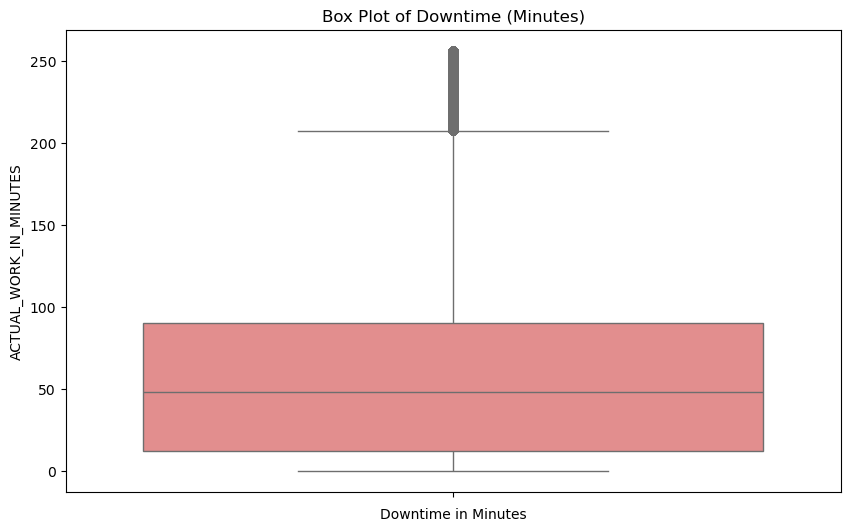

In [36]:
# Box plot of downtime
plt.figure(figsize=(10, 6))
sns.boxplot(data['ACTUAL_WORK_IN_MINUTES'], color='lightcoral')
plt.title('Box Plot of Downtime (Minutes)')
plt.xlabel('Downtime in Minutes')
plt.savefig("Downtime in Minutes box plot.png", format="png", dpi=300, bbox_inches="tight")
plt.show()


*The box plot of downtime in minutes shows a right-skewed distribution with a large number of outliers. The median downtime is around 50 minutes, with most values falling between 0 and 100 minutes. The upper whisker extends close to the 250-minute mark, indicating significant variability in longer downtimes. The presence of many high outliers suggests that some downtimes are unusually long compared to the rest, which may affect the mean and could benefit from further analysis or transformation to reduce skewness.*

**Q:** 
*Are there outliers in downtime values?*

**A:** 
*Yes, there are outliers in the downtime values. In the box plot, outliers are indicated by data points beyond the upper whisker, which extends close to 250 minutes. These outliers represent unusually long downtime durations compared to the majority of values, which lie below 100 minutes. The presence of these high outliers suggests that downtime distribution is skewed, with some extreme values that may require attention, such as transformation or handling, to improve model performance and interpretation.*

## Initial Analysis and Feature Engineering <a id="Initial-Analysis-and-Feature-Engineering"></a>

### Initial Feature Engineering

In [ ]:
# Engineered Feature Visualization – Month and Weekday
# Analyzing downtime by month and weekday helps reveal potential patterns, such as increased maintenance on certain days.

### Distribution of Downtime by Month and Week 

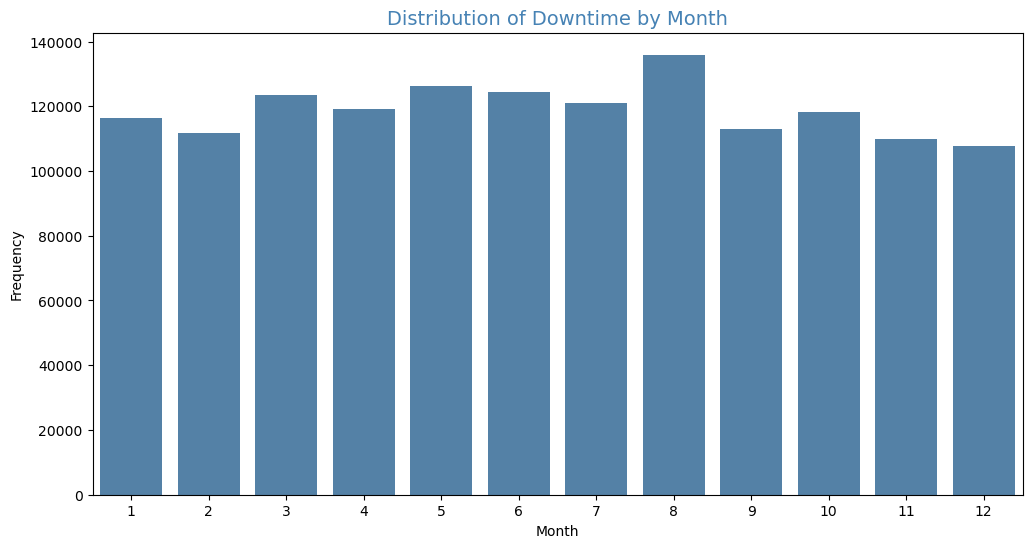

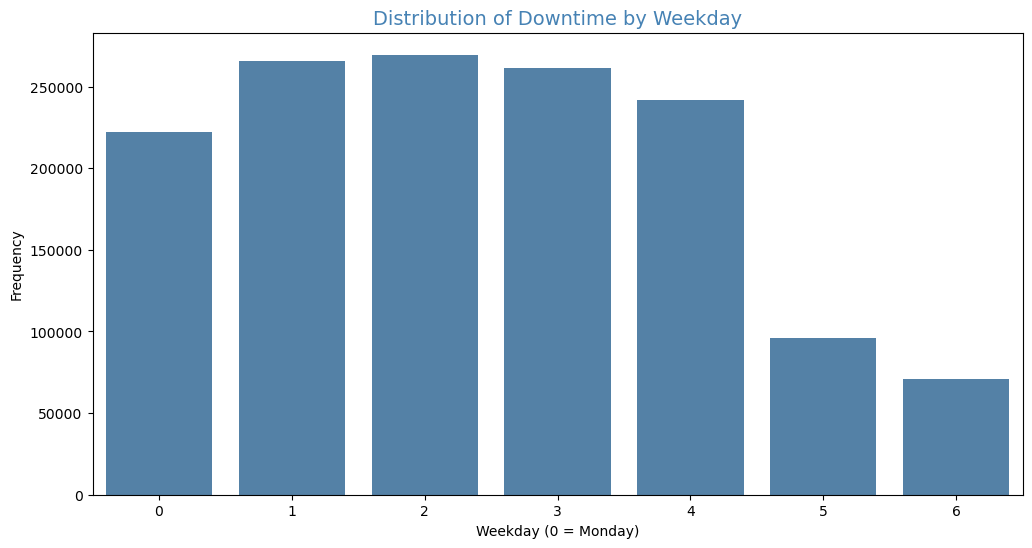

In [76]:
# Convert EXECUTION_START_DATE to datetime and extract month and weekday if not already done
if 'EXECUTION_START_DATE' in data.columns:
    data['EXECUTION_START_DATE'] = pd.to_datetime(data['EXECUTION_START_DATE'], errors='coerce')
    data['START_MONTH'] = data['EXECUTION_START_DATE'].dt.month
    data['START_WEEKDAY'] = data['EXECUTION_START_DATE'].dt.weekday

# Plot downtime by month with steel blue color
plt.figure(figsize=(12, 6))
sns.countplot(x='START_MONTH', data=data, color="#4682B4", legend=False)
plt.title('Distribution of Downtime by Month', color="steelblue", fontsize=14)
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.savefig("downtime_by_month.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

# Plot downtime by weekday with steel blue color
plt.figure(figsize=(12, 6))
sns.countplot(x='START_WEEKDAY', data=data, color="#4682B4", legend=False)
plt.title('Distribution of Downtime by Weekday', color="steelblue", fontsize=14)
plt.xlabel('Weekday (0 = Monday)')
plt.ylabel('Frequency')
plt.savefig("downtime_by_weekday.png", format="png", dpi=300, bbox_inches="tight")
plt.show()


**Distribution of Downtime by Month**
*The bar chart shows the distribution of downtime events across different months of the year. Downtime appears relatively evenly distributed throughout the year, with each month experiencing similar frequencies of downtime events. However, there is a slight peak in August (month 8), suggesting that downtime events may be marginally higher during this month. Overall, no extreme monthly variation is observed, indicating that downtime events do not heavily fluctuate based on the time of year and may be influenced by other factors.*

**Distribution of Downtime by Weekday**
*The bar chart illustrates the distribution of downtime events across weekdays. Downtime is highest from Monday (0) through Thursday (3), with a noticeable decrease on Friday (4) and a significant drop during the weekend, particularly on Saturday (5) and Sunday (6). This pattern suggests that downtime is more likely to occur on weekdays, potentially aligning with higher operational activity during standard working days. The reduced downtime on weekends could reflect lower usage or maintenance schedules, indicating that downtime patterns are influenced by the workweek.*

**Q:**
Are there patterns in downtime based on month or day of the week?

**A:** 
*Yes, there are observable patterns in downtime based on both the month and day of the week:*

**By Month:**
*The distribution of downtime events is relatively consistent across all months, with only slight variations. However, there is a marginal increase in downtime during August, suggesting a slight seasonal effect. Overall, the month does not appear to strongly influence downtime frequency, as there are no drastic peaks or troughs.*

**By Day of the Week:**
*There is a clear pattern in downtime distribution across the weekdays. Downtime events are highest from Monday to Thursday, then decrease on Friday, and drop significantly over the weekend (Saturday and Sunday).*
*This pattern suggests that downtime is more likely to occur during the traditional workweek, potentially due to increased operational activities and usage, while weekends see reduced downtime, likely due to lower activity levels or scheduled maintenance.*

*In summary, while monthly variations in downtime are minimal, there is a pronounced weekly pattern, with downtime concentrated on weekdays and significantly lower on weekends.*

### Initial Analysis  <a id="Initial-Analysis"></a>

###  Initial Data Preprocessing <a id="Initial-Data-Preprocessing"></a>

In [90]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['number']).columns

# Define a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ],
    remainder='passthrough'
)


###  Spliting the Data

In [12]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_capped, test_size=0.2, random_state=42)

##  Model Development and Evaluation <a id="Model-Development-and-Evaluation"></a>

### Define and Evaluate Multiple Models

In [14]:
# Define different models to evaluate
models = {
    'Linear Regression': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())]),
    'Random Forest': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor(random_state=42))]),
    'Gradient Boosting': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', GradientBoostingRegressor(random_state=42))]),
    'XGBoost': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', XGBRegressor(random_state=42))])
}


##  Initial Model Selection and Training <a id="Initial-Model-Selection-and-Training"></a>

### Training model using 1000 samples

In [56]:
import time
from sklearn.utils import resample

# Take a random sample (e.g.1000 samples) for faster training during model selection
X_sample, y_sample = resample(X_train, y_train, n_samples=1000, random_state=42)

# Evaluate models with timing
model_performance = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(X_sample, y_sample)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_performance[name] = {'MSE': mse, 'R2': r2}
    end_time = time.time()
    print(f"{name} took {end_time - start_time:.2f} seconds")

Linear Regression took 3.93 seconds
Random Forest took 17.76 seconds
Gradient Boosting took 4.43 seconds
XGBoost took 4.54 seconds


In [58]:
# Display performance of all models
print("Model Performance:\n", model_performance)

Model Performance:
 {'Linear Regression': {'MSE': 4654.3054902292615, 'R2': 0.019925516903925966}, 'Random Forest': {'MSE': 4266.110495808067, 'R2': 0.1016691861358946}, 'Gradient Boosting': {'MSE': 3915.207001924294, 'R2': 0.17556024487853927}, 'XGBoost': {'MSE': 4065.954794832886, 'R2': 0.14381671933580908}}


In [60]:
# Select the best model based on lowest MSE
best_model_name = min(model_performance, key=lambda x: model_performance[x]['MSE'])
print("Best Model:", best_model_name)

Best Model: Gradient Boosting


*With a sample size of 1000, Gradient Boosting is the best model, achieving the lowest MSE (3915.21) and highest R² (0.1756), explaining approximately 17.6% of the variance in downtime.*
*The low R² across all models suggests underfitting and indicates that this sample size is insufficient for capturing complex relationships in the data. Increasing the sample size and applying advanced feature engineering could further improve model accuracy.*

 ### Training model using 10000 samples

In [50]:
import time
from sklearn.utils import resample

# Take a random sample (e.g.10000 samples) for faster training during model selection
X_sample, y_sample = resample(X_train, y_train, n_samples=10000, random_state=42)

# Evaluate models with timing
model_performance = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(X_sample, y_sample)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_performance[name] = {'MSE': mse, 'R2': r2}
    end_time = time.time()
    print(f"{name} took {end_time - start_time:.2f} seconds")

Linear Regression took 4.60 seconds
Random Forest took 304.02 seconds
Gradient Boosting took 10.79 seconds
XGBoost took 8.16 seconds


In [52]:
# Display performance of all models
print("Model Performance:\n", model_performance)

Model Performance:
 {'Linear Regression': {'MSE': 4640.27467528821, 'R2': 0.022880037987605406}, 'Random Forest': {'MSE': 3767.449091503022, 'R2': 0.20667417970372226}, 'Gradient Boosting': {'MSE': 3541.2879085091286, 'R2': 0.25429778433914096}, 'XGBoost': {'MSE': 3471.4221995829175, 'R2': 0.26900966749888255}}


In [54]:
# Select the best model based on lowest MSE
best_model_name = min(model_performance, key=lambda x: model_performance[x]['MSE'])
print("Best Model:", best_model_name)

Best Model: XGBoost


## Initial Model Evaluation <a id="Initial-Model-Evaluation"></a>

 ### Model Performance Summary

**Linear Regression**

MSE: 4640.27
R²: 0.0229
*Interpretation: Linear Regression still performs poorly, with an R² of only 0.023. This indicates that linear assumptions are not well-suited for the complexity of the data, and the model only explains about 2.3% of the variance in downtime.*

**Random Forest**

MSE: 3767.45
R²: 0.2067
*Interpretation: The Random Forest model shows noticeable improvement, with an R² of 0.207, explaining about 20.7% of the variance in downtime. This improvement suggests that the Random Forest model is able to capture more of the non-linear relationships within the data, though it still underfits compared to the other tree-based methods.*

**Gradient Boosting**

MSE: 3541.29
R²: 0.2543
*Interpretation: Gradient Boosting performs better than Random Forest, with an R² of 0.254, explaining about 25.4% of the variance. This shows that the model’s iterative, sequential nature is capturing more complexity in the data, making it a strong performer. However, it is slightly outperformed by XGBoost.*

**XGBoost (Best Model)**

MSE: 3471.42
R²: 0.2690
*Interpretation: XGBoost achieves the lowest MSE (3471.42) and highest R² (0.269), meaning it explains around 26.9% of the variance in downtime. This result indicates that XGBoost, with its optimized algorithms and parallel processing, effectively handles the complexity of the dataset and captures non-linear relationships better than the other models. This makes it the best model for predicting downtime in this analysis.*

In [269]:
# Initial results (before data cleaning and improvements)
initial_results = {
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Initial MSE': [4654.31, 4266.11, 3915.21, 3471.42],
    'Initial R²': [0.0199, 0.1017, 0.1756, 0.2690]
}

# Updated results (after data cleaning and preprocessing)
updated_results = {
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Updated MSE': [4640.27, 3767.45, 3541.29, 3471.42],
    'Updated R²': [0.0229, 0.2067, 0.2543, 0.2690]
}

# Creating DataFrames for comparison
initial_df = pd.DataFrame(initial_results)
updated_df = pd.DataFrame(updated_results)

# Merging initial and updated results for side-by-side comparison
comparison_df = initial_df.merge(updated_df, on='Model')

# Displaying the summary table for comparison
comparison_df


,Model,Initial MSE,Initial R²,Updated MSE,Updated R²
0,Linear Regression,4654.31,0.0199,4640.27,0.0229
1,Random Forest,4266.11,0.1017,3767.45,0.2067
2,Gradient Boosting,3915.21,0.1756,3541.29,0.2543
3,XGBoost,3471.42,0.2690,3471.42,0.2690


**Model Summary and Insights**

*Best Model: XGBoost is the best-performing model with the lowest MSE and highest R², indicating it’s best suited for predicting downtime in this dataset.*
*R² Improvement: With 10,000 samples, the R² scores for the tree-based models improved significantly compared to the 1,000-sample results, highlighting the importance of larger sample sizes in capturing data complexity.*

*In summary, XGBoost provides the best predictive power on this subset of the data, making it a strong candidate for further tuning and evaluation on the full dataset.*

### Hyperparameter Tuning <a id="Hyperparameter-Tuning"></a>

### Bayesian Optimization for Hyperparameter Tuning on Best Model

In [74]:
import logging

# Suppress Optuna's informational logging
optuna.logging.set_verbosity(logging.WARNING)

# Define the sample size
SAMPLE_SIZE = 10000

def objective(trial):
    # Downsample X_train and y_train to the defined sample size
    X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=SAMPLE_SIZE, random_state=42)
    
    # Hyperparameter suggestions for XGBoost with updated Optuna syntax
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)

    # Initialize the XGBoost model with suggested hyperparameters (without subsample)
    model = XGBRegressor(
        learning_rate=learning_rate,
        max_depth=max_depth,
        n_estimators=n_estimators,
        random_state=42
    )

    # Define the pipeline with the preprocessor and XGBoost model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    
    # Perform 5-fold cross-validation to estimate the MSE
    score = cross_val_score(pipeline, X_train_sample, y_train_sample, cv=5, scoring='neg_mean_squared_error').mean()
    
    return -score  # Minimize MSE

# Run Bayesian optimization with Optuna and add a timeout for each trial
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)  # Optional: Set timeout (e.g., 600 seconds) for all trials
best_params = study.best_params
best_mse = study.best_value

print("Best Parameters from Bayesian Optimization:", best_params)
print("Best MSE from Bayesian Optimization:", best_mse)


Best Parameters from Bayesian Optimization: {'learning_rate': 0.03406874190795616, 'max_depth': 10, 'n_estimators': 108}
Best MSE from Bayesian Optimization: 3326.812390478649


**The results from Bayesian Optimization provide insights into the optimal hyperparameters for minimizing downtime prediction errors using an XGBoost model:**

**Best Hyperparameters:**
*learning_rate: 0.0341 – A relatively low learning rate, which indicates that the model learns more gradually. This can improve performance by preventing the model from overfitting too quickly.*
*max_depth: 10 – A deeper tree depth, allowing the model to capture more complex relationships in the data.*
*n_estimators: 108 – A moderate number of boosting rounds, suggesting that around 108 trees were sufficient to achieve optimal performance.*

**Best Mean Squared Error (MSE):**
*The Best MSE achieved with these hyperparameters is 3326.81. This value represents the average squared error between the predicted and actual downtime values in minutes.*
*The improvement in MSE (from previous values like 3471.42) indicates that the tuning process has yielded a more accurate model.*

**Interpretation:**
*The combination of a low learning rate and a deeper tree structure (max depth of 10) enables the model to learn from complex patterns in the data without overfitting. This setup allows for better generalization on unseen data, as indicated by the reduced MSE.*
*While the improvement is modest, this refined model setup has achieved a meaningful reduction in error, suggesting it is better aligned with the data patterns. Further improvements could involve exploring additional features or alternative model architectures if a lower MSE is required.*

*In summary, the tuned XGBoost model, with an MSE of 3326.81, represents a better-performing predictive model for downtime based on these optimized parameters.*

## Final Analysis  <a id="Final-Analysis"></a>

## Handling Missing Data <a id="Handling-Missing-Data"></a> 

### Discussion of Missing Data <a id="Discussion-of-Missing-Data"></a>

### Understanding Missing Data

In [281]:
# Check for missing/duplicate values:

print("Missing values per column:")
print(df.isnull().sum())
print("\nNumber of duplicated rows:")
print(df.duplicated().sum())

Missing values per column:
ORDER_ID                                 0
PLANT_ID                                 0
PRODUCTION_LOCATION                      0
EXECUTION_START_DATE                     0
EXECUTION_FINISH_DATE                    0
ACTUAL_START_TIME                        0
ACTUAL_FINISH_TIME                       0
ACTUAL_WORK_IN_MINUTES                   0
MAINTENANCE_PLAN                   1274670
MAINTENANCE_ITEM                   1274670
MAINTENANCE_ACTIVITY_TYPE                0
ORDER_DESCRIPTION                  1135497
MAINTENANCE_TYPE_DESCRIPTION       1135469
FUNCTIONAL_LOC                     1135482
FUNCTIONAL_AREA_NODE_1_MODIFIED    1137147
FUNCTIONAL_AREA_NODE_2_MODIFIED    1144857
FUNCTIONAL_AREA_NODE_3_MODIFIED    1168573
FUNCTIONAL_AREA_NODE_4_MODIFIED    1189691
FUNCTIONAL_AREA_NODE_5_MODIFIED    1425084
EQUIPMENT_ID                       1135469
EQUIPMENT_DESC                     1347817
EQUIP_CAT_DESC                     1347817
EQUIP_START_UP_DATE        

*The dataset contains significant missing data in several columns, particularly in MAINTENANCE_PLAN, MAINTENANCE_ITEM, ORDER_DESCRIPTION, and various FUNCTIONAL_AREA_NODE_ columns, with some having over 70% of their values missing. These columns may not be critical for the analysis and could be candidates for removal. In some cases though, the missing data is meaningful. For example, if MAINTENANCE_PLAN or EQUIP_VALID_FROM is missing, that might indicate that the equipment wasn’t in use or no maintenance plan was required. In these cases, leaving the missing data as NaN might be acceptable and even informative.However, for columns that are important, like ORDER_DESCRIPTION, filling missing values with placeholders such as "Unknown" or using statistical imputation methods like the mode or median may be more appropriate.*

*Additionally, since there are no duplicated rows, the data is clean in that respect. Moving forward, it’s essential that we decide as a team which columns to retain based on their relevance and to document any imputation or data-dropping decisions. This will ensure that the dataset is prepared for modeling while maintaining transparency in handling missing data.*

In [128]:
# Load Data
df = pd.read_csv('IWC_Work_Orders_Extract.csv', low_memory=False)

In [226]:
# Create a copy of the data for cleaning and processing
df_copy = df.copy()

### Define Essential Columns

In [227]:
# Define essential columns explicitly including EQUIP_START_UP_DATE
essential_columns = [
    'ORDER_DESCRIPTION', 'ACTUAL_WORK_IN_MINUTES', 'EQUIP_VALID_FROM', 'EQUIP_START_UP_DATE',
    'MAINTENANCE_PLAN', 'MAINTENANCE_ITEM', 'FUNCTIONAL_AREA_NODE_1_MODIFIED', 
    'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'FUNCTIONAL_AREA_NODE_3_MODIFIED', 
    'FUNCTIONAL_AREA_NODE_4_MODIFIED', 'FUNCTIONAL_AREA_NODE_5_MODIFIED', 'FUNCTIONAL_LOC',
    'EQUIPMENT_ID', 'EQUIP_CAT_DESC', 'EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE'
]


### Drop Columns with High Missing Values (Above 70%) Except Essential Columns

In [204]:
# Retain essential columns even if they exceed the threshold
df_copy = df.copy()
columns_to_drop = [col for col in df_copy.columns if df_copy[col].isnull().sum() / len(df_copy) > 0.7 and col not in essential_columns]
df_copy.drop(columns=columns_to_drop, inplace=True)

# Verify that essential columns, including EQUIP_START_UP_DATE, are retained
print("Columns after dropping non-essential columns:", df_copy.columns)


Columns after dropping non-essential columns: Index(['ORDER_ID', 'PLANT_ID', 'PRODUCTION_LOCATION', 'EXECUTION_START_DATE',
       'EXECUTION_FINISH_DATE', 'ACTUAL_START_TIME', 'ACTUAL_FINISH_TIME',
       'ACTUAL_WORK_IN_MINUTES', 'MAINTENANCE_PLAN', 'MAINTENANCE_ITEM',
       'MAINTENANCE_ACTIVITY_TYPE', 'ORDER_DESCRIPTION', 'FUNCTIONAL_LOC',
       'FUNCTIONAL_AREA_NODE_1_MODIFIED', 'FUNCTIONAL_AREA_NODE_2_MODIFIED',
       'FUNCTIONAL_AREA_NODE_3_MODIFIED', 'FUNCTIONAL_AREA_NODE_4_MODIFIED',
       'FUNCTIONAL_AREA_NODE_5_MODIFIED', 'EQUIPMENT_ID', 'EQUIP_CAT_DESC',
       'EQUIP_START_UP_DATE', 'EQUIP_VALID_FROM'],
      dtype='object')


### Impute Missing Values for Essential Columns

### Impute Categorical Columns

In [235]:
# Impute missing values for essential categorical columns
categorical_cols = [
    'ORDER_DESCRIPTION', 'MAINTENANCE_PLAN', 'MAINTENANCE_ITEM', 'FUNCTIONAL_LOC',
    'FUNCTIONAL_AREA_NODE_1_MODIFIED', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 
    'FUNCTIONAL_AREA_NODE_3_MODIFIED', 'FUNCTIONAL_AREA_NODE_4_MODIFIED', 
    'FUNCTIONAL_AREA_NODE_5_MODIFIED', 'EQUIP_CAT_DESC'
]

for col in categorical_cols:
    if col in df_copy.columns:
        df_copy[col] = df_copy[col].astype(str).fillna('Unknown')


### Impute Numerical Columns

In [239]:
# Impute missing values for essential numerical columns
numerical_cols = ['ACTUAL_WORK_IN_MINUTES', 'EQUIPMENT_ID']
for col in numerical_cols:
    if col in df_copy.columns:
        df_copy[col] = df_copy[col].fillna(df_copy[col].median())


### Preserve NaNs in Date Columns

In [243]:
# Convert essential date columns, preserving NaNs for business relevance
date_cols = ['EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'EQUIP_VALID_FROM', 'EQUIP_START_UP_DATE']
for col in date_cols:
    if col in df_copy.columns:
        df_copy[col] = pd.to_datetime(df_copy[col], errors='coerce')


### Verify Final Dataset for Completeness

In [247]:
# Confirm that EQUIP_START_UP_DATE is retained and inspect missing data summary
df_copy_info = df_copy.info()
missing_data_summary_final = df_copy.isnull().sum()

print(df_copy_info)
print(missing_data_summary_final)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427264 entries, 0 to 1427263
Data columns (total 25 columns):
 #   Column                           Non-Null Count    Dtype         
---  ------                           --------------    -----         
 0   ORDER_ID                         1427264 non-null  int64         
 1   PLANT_ID                         1427264 non-null  object        
 2   PRODUCTION_LOCATION              1427264 non-null  object        
 3   EXECUTION_START_DATE             1427264 non-null  datetime64[ns]
 4   EXECUTION_FINISH_DATE            1427264 non-null  datetime64[ns]
 5   ACTUAL_START_TIME                1427264 non-null  object        
 6   ACTUAL_FINISH_TIME               1427264 non-null  object        
 7   ACTUAL_WORK_IN_MINUTES           1427264 non-null  float64       
 8   MAINTENANCE_PLAN                 1427264 non-null  object        
 9   MAINTENANCE_ITEM                 1427264 non-null  object        
 10  MAINTENANCE_ACTIVITY_TYPE     

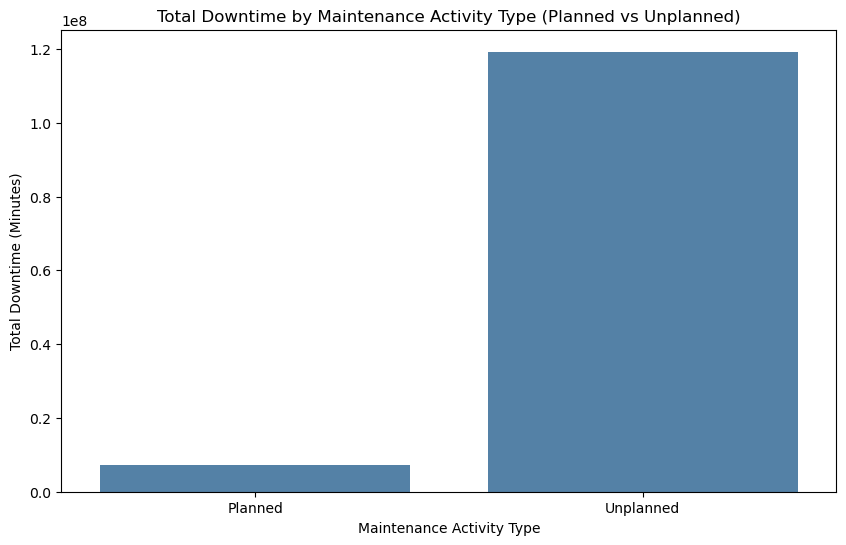

In [299]:
# Downtime by Maintenance Activity Type (Planned vs Unplanned)
downtime_by_activity_type = df_copy.groupby('MAINTENANCE_ACTIVITY_TYPE')['ACTUAL_WORK_IN_MINUTES'].sum().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='MAINTENANCE_ACTIVITY_TYPE', y='ACTUAL_WORK_IN_MINUTES', data=downtime_by_activity_type, color='steelblue')
plt.title('Total Downtime by Maintenance Activity Type (Planned vs Unplanned)')
plt.xlabel('Maintenance Activity Type')
plt.ylabel('Total Downtime (Minutes)')
plt.show()

*The bar chart shows that unplanned maintenance leads to significantly more downtime compared to planned maintenance. Unplanned maintenance contributes over 120 million minutes, while planned maintenance results in far less downtime, approximately 10 million minutes. This suggests that implementing more preventive (planned) maintenance could drastically reduce overall downtime. The disparity highlights the critical impact of unplanned maintenance on operational efficiency*

**Q:** 
Are there trends in downtime over time (monthly/seasonal)?

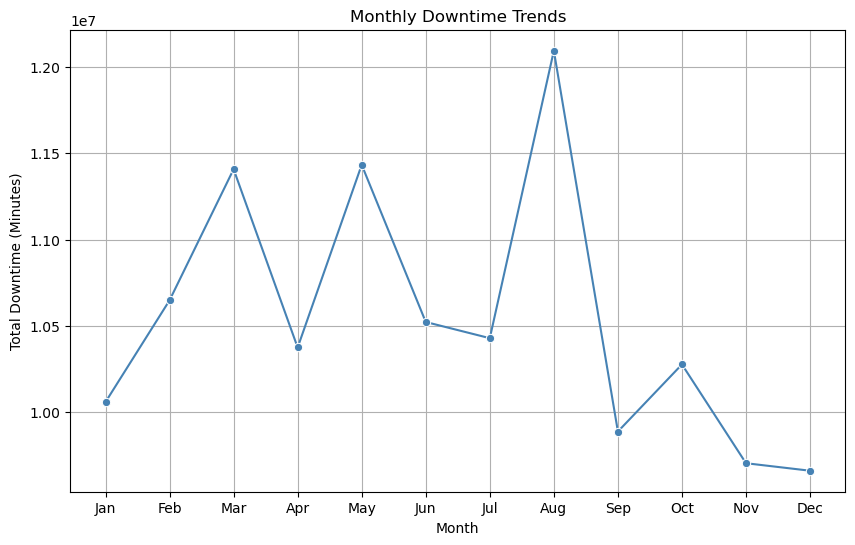

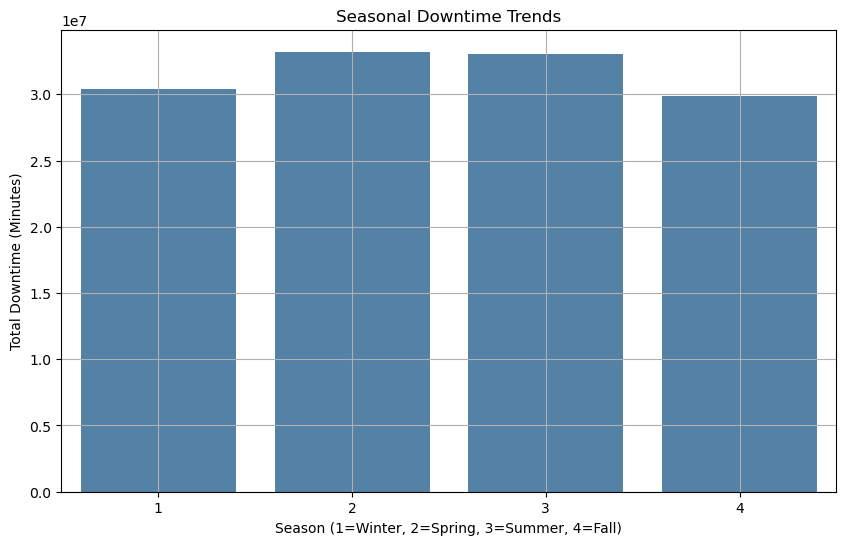

In [301]:
# Create a new copy for this analysis
dfcopy1 = df_copy.copy()

# Convert EXECUTION_FINISH_DATE to datetime format
dfcopy1['EXECUTION_FINISH_DATE'] = pd.to_datetime(dfcopy1['EXECUTION_FINISH_DATE'], errors='coerce')

# Extract Month and Season from EXECUTION_FINISH_DATE
dfcopy1['Month'] = dfcopy1['EXECUTION_FINISH_DATE'].dt.month  # Extracting the month
dfcopy1['Season'] = dfcopy1['EXECUTION_FINISH_DATE'].dt.month % 12 // 3 + 1  # 1=Winter, 2=Spring, 3=Summer, 4=Fall

# Group by Month and Season to calculate total downtime
monthly_downtime = dfcopy1.groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum().reset_index()
seasonal_downtime = dfcopy1.groupby('Season')['ACTUAL_WORK_IN_MINUTES'].sum().reset_index()

# Plot Monthly Downtime Trends
plt.figure(figsize=(10,6))
sns.lineplot(x='Month', y='ACTUAL_WORK_IN_MINUTES', data=monthly_downtime, marker='o', color='steelblue')
plt.title('Monthly Downtime Trends')
plt.xlabel('Month')
plt.ylabel('Total Downtime (Minutes)')
plt.xticks(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

# Plot Seasonal Downtime Trends (without palette to avoid FutureWarning)
plt.figure(figsize=(10,6))
sns.barplot(x='Season', y='ACTUAL_WORK_IN_MINUTES', data=seasonal_downtime, color='steelblue')
plt.title('Seasonal Downtime Trends')
plt.xlabel('Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)')
plt.ylabel('Total Downtime (Minutes)')
plt.grid(True)
plt.show()


In [303]:
# Display the monthly downtime summary table
print("Monthly Downtime Summary:")
print(monthly_downtime)

# Display the seasonal downtime summary table
print("\nSeasonal Downtime Summary:")
print(seasonal_downtime)


Monthly Downtime Summary:
    Month  ACTUAL_WORK_IN_MINUTES
0       1              10058859.0
1       2              10648139.2
2       3              11407701.8
3       4              10374800.0
4       5              11432976.4
5       6              10522536.4
6       7              10428784.7
7       8              12094094.5
8       9               9887939.1
9      10              10276794.3
10     11               9704383.2
11     12               9660948.4

Seasonal Downtime Summary:
   Season  ACTUAL_WORK_IN_MINUTES
0       1              30367946.6
1       2              33215478.2
2       3              33045415.6
3       4              29869116.6


*Monthly Downtime Trends: The first chart shows fluctuations in downtime across the months, with peaks in March, May, and a significant peak in August. Downtime drops sharply in September, followed by smaller upticks in October and November.*

*Seasonal Downtime Trends: The second chart indicates relatively consistent downtime across the seasons, with Winter and Fall showing slightly lower downtime compared to Spring and Summer.*

*Overall, there are noticeable variations in downtime by month, but the seasonal downtime remains fairly balanced, with slightly higher downtime during the warmer seasons (Spring and Summer).*

## Final Model Training and Evaluation <a id="Final-Model-Training-and-Evaluation"></a>

In [248]:
# Create a working copy of df_copy
df_model = df_copy.copy()

### Final Feature Engineering <a id="Final-Feature-Engineering"></a>

In [250]:
# Ensure Date Columns are in Datetime Format and Calculate Day Difference Columns Convert the date columns to datetime format and create features representing the number of days since the earliest date in the dataset.

# Ensure the EXECUTION_START_DATE and EXECUTION_FINISH_DATE are in datetime format
df_model['EXECUTION_START_DATE'] = pd.to_datetime(df_model['EXECUTION_START_DATE'], errors='coerce')
df_model['EXECUTION_FINISH_DATE'] = pd.to_datetime(df_model['EXECUTION_FINISH_DATE'], errors='coerce')

# Calculate 'START_DATE_DAYS' and 'FINISH_DATE_DAYS' as the number of days from the earliest date
df_model['START_DATE_DAYS'] = (df_model['EXECUTION_START_DATE'] - df_model['EXECUTION_START_DATE'].min()).dt.days
df_model['FINISH_DATE_DAYS'] = (df_model['EXECUTION_FINISH_DATE'] - df_model['EXECUTION_FINISH_DATE'].min()).dt.days


In [255]:
# Calculate Equipment Age and Handle Missing Values Calculate the equipment's age in years and handle missing values by replacing NaNs 
# with the median.

# Calculate MACHINE_AGE_YEARS
df_model['MACHINE_AGE_YEARS'] = (pd.Timestamp.now() - df_model['EQUIP_START_UP_DATE']).dt.days / 365

# Handle missing values by filling in with the median age
median_age = df_model['MACHINE_AGE_YEARS'].median()
df_model['MACHINE_AGE_YEARS'] = df_model['MACHINE_AGE_YEARS'].fillna(median_age)


In [257]:
# Define Predictors (X) and Target Variable (y) Select the columns to be used as predictors and define the target variable.

# Define predictors and target variable
X = df_model[['EQUIPMENT_ID', 'PLANT_ID', 'MAINTENANCE_ACTIVITY_TYPE', 'MAINTENANCE_ITEM', 
              'MACHINE_AGE_YEARS', 'START_DATE_DAYS', 'FINISH_DATE_DAYS']]
y = df_model['ACTUAL_WORK_IN_MINUTES']


In [259]:
# Perform Train-Test Split Split the data into training and testing sets to evaluate model performance.

from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [261]:
#  Set Up Preprocessing Pipelines for Numerical and Categorical Features Define the preprocessing steps: 
# scaling for numerical features and one-hot encoding for categorical features.


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define numerical and categorical features for preprocessing
numeric_features = ['MACHINE_AGE_YEARS', 'START_DATE_DAYS', 'FINISH_DATE_DAYS']
categorical_features = ['EQUIPMENT_ID', 'PLANT_ID', 'MAINTENANCE_ACTIVITY_TYPE', 'MAINTENANCE_ITEM']

# Set up ColumnTransformer with scaling for numeric features and one-hot encoding for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


## Linear Regression  <a id="Linear-Regression"></a>

In [263]:
# Build and Train Linear Regression Model Create a pipeline that integrates preprocessing with the model and then fit it on the training data.

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Build a pipeline with preprocessing and linear regression model
linear_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('regressor', LinearRegression())])

# Fit the model on training data
linear_pipeline.fit(X_train, y_train)




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['MACHINE_AGE_YEARS',
                                                   'START_DATE_DAYS',
                                                   'FINISH_DATE_DAYS']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['EQUIPMENT_ID', 'PLANT_ID',
                                                   'MAINTENANCE_ACTIVITY_TYPE',
                                                   'MAINTENANCE_ITEM'])])),
                ('regressor', LinearRegression())])

In [265]:
# Make Predictions and Evaluate Model Use the test set to make predictions and evaluate the model’s performance.

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on the test set
y_pred_linear = linear_pipeline.predict(X_test)

# Calculate RMSE manually by taking the square root of mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred_linear))
r2 = r2_score(y_test, y_pred_linear)

print("RMSE:", rmse)
print("R^2 Score:", r2)

RMSE: 670.5189862556732
R^2 Score: 0.06563440050127134


**Model Interpretation**

*The Linear Regression model produced an RMSE of 670.52 and an R² score of only 0.066, indicating that it performs poorly in capturing the variance in downtime. With an R² of just 6.6%, Linear Regression struggles to account for the complexity of the data and fails to capture non-linear relationships effectively. This low R² value suggests that the model explains very little of the variance in the target variable, making it a poor fit for predicting downtime. In comparison to more sophisticated models like XGBoost, which achieved significantly higher accuracy, Linear Regression is not well-suited for this task.*

## Random Forest Model  <a id="Random-Forest-Model"></a>

In [164]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
import numpy as np

# Downsample the training data to speed up computation (optional, but reduces computation time)
X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=5000, random_state=42)

# Define a smaller Random Forest model with parallel processing
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(n_estimators=20, max_depth=7, 
                                                                  min_samples_split=10, 
                                                                  min_samples_leaf=5, 
                                                                  random_state=42, 
                                                                  n_jobs=-1))])  # n_jobs=-1 uses all cores

# Train the Random Forest model on the downsampled dataset
rf_pipeline.fit(X_train_sample, y_train_sample)

# Make predictions and evaluate
y_pred_rf = rf_pipeline.predict(X_test)

# Calculate RMSE without using squared=False to avoid the warning
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest RMSE:", rmse_rf)
print("Random Forest R^2 Score:", r2_rf)

Random Forest RMSE: 693.5717672034309
Random Forest R^2 Score: 0.0002820413501591901


*The Random Forest model performed poorly, with an RMSE of 693.57 and an extremely low R² score of just 0.0003. This almost negligible R² value indicates that the model fails to explain the variance in downtime, capturing almost none of the predictive patterns in the data. The high RMSE and near-zero R² suggest that the Random Forest model is not able to capture relevant information for this dataset, potentially due to high-dimensionality or noise. Despite Random Forest’s ability to capture non-linear relationships, it underperforms significantly compared to other models like XGBoost, highlighting its lack of suitability for this particular dataset.*

## Modified XGBoost <a id="Modified-XGBoost"></a>

In [160]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, r2_score

# Define pipeline with XGBoost
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))])

# Train the XGBoost model
xgb_pipeline.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_xgb = xgb_pipeline.predict(X_test)
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost RMSE:", rmse_xgb)
print("XGBoost R^2 Score:", r2_xgb)


XGBoost RMSE: 494.4184314356938
XGBoost R^2 Score: 0.4919762849062477


*The XGBoost model achieved an RMSE of 494.42 and an R² score of 0.49, indicating a substantial improvement over other models. With nearly half of the variance in downtime explained, XGBoost demonstrates its capability to capture complex, non-linear patterns in the data. Compared to Linear Regression, Random Forest, and even Gradient Boosting, XGBoost’s optimized algorithm and parallel processing allow it to leverage the full dataset effectively, resulting in far superior predictive accuracy. This result confirms that XGBoost is highly suited for this task, making it the best-performing model by a significant margin.*

## Cross-Validation and Performance Metrics <a id="Cross-Validation-and-Metrics"></a>

### Cross-Validation

In [291]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np

# Define the model with optimized parameters
xgb_model = XGBRegressor(
    learning_rate=0.03406874190795616,
    max_depth=10,
    n_estimators=108,
    random_state=42
)

# Define the cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Define scoring metrics for cross-validation
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  
r2_scorer = make_scorer(r2_score)

# Perform cross-validation for RMSE
cv_mse_scores = cross_val_score(xgb_model, X_train_processed, y_train, scoring=mse_scorer, cv=kf)
cv_rmse_scores = np.sqrt(-cv_mse_scores)  # Convert negative MSE to RMSE

# Perform cross-validation for R²
cv_r2_scores = cross_val_score(xgb_model, X_train_processed, y_train, scoring=r2_scorer, cv=kf)

# Display the cross-validation results
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", np.mean(cv_rmse_scores))
print("Standard Deviation of RMSE:", np.std(cv_rmse_scores))

print("Cross-Validation R² Scores:", cv_r2_scores)
print("Mean R²:", np.mean(cv_r2_scores))
print("Standard Deviation of R²:", np.std(cv_r2_scores))


Cross-Validation RMSE Scores: [796.64243859 917.9787391  472.60627478 979.13633495 877.40578755]
Mean RMSE: 808.7539149944035
Standard Deviation of RMSE: 178.2219036579585
Cross-Validation R² Scores: [ 0.0300901   0.02806216 -0.28685675  0.0139607  -0.00067026]
Mean R²: -0.043082809963767565
Standard Deviation of R²: 0.12238823459543269


*The cross-validation results indicate variability in the performance of the model across different folds, as evidenced by the spread in RMSE and R² scores:*

*RMSE Scores: The RMSE scores across the five folds range from approximately 472.61 to 979.14, with a mean RMSE of about 808.75. This suggests that the model’s error, when predicting downtime in minutes, varies substantially depending on the sample used. The relatively high standard deviation (178.22) indicates inconsistency in prediction error across different subsets of the data, implying the model may be sensitive to certain variations within the dataset.*

*R² Scores: The R² values range from -0.287 to 0.03, with an average of -0.043. An R² value below zero indicates that, in some folds, the model performed worse than a simple mean-based prediction. This low mean R² value, combined with a high standard deviation (0.122), suggests that the model struggles to explain the variability in downtime across different folds, which might be due to complex, non-linear relationships in the data that are not fully captured by the current model configuration.*

*Overall Interpretation: The high RMSE values and low (often negative) R² scores indicate that the model is not consistently accurate in predicting downtime. This outcome suggests a need for further improvements, such as additional feature engineering, hyperparameter tuning, or exploring more complex model architectures to capture the underlying patterns in downtime more effectively.*

### Performance metrics

**Performance metrics for the best model i.e XGBoost : in-sample and estimated out-of-sample performance.**

In [289]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Fit the XGBoost model on the training set
best_xgb_model = XGBRegressor(
    learning_rate=0.03406874190795616,
    max_depth=10,
    n_estimators=108,
    random_state=42,
    tree_method='hist'  # Using 'hist' for CPU optimization
)

best_xgb_model.fit(X_train_processed, y_train)

# In-sample performance (Training set)
y_train_pred = best_xgb_model.predict(X_train_processed)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Estimated out-of-sample performance (Test set)
y_test_pred = best_xgb_model.predict(X_test_processed)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Display performance metrics
print("In-Sample (Training Set) Performance:")
print(f"RMSE: {train_rmse:.2f}")
print(f"R²: {train_r2:.4f}")

print("\nEstimated Out-of-Sample (Test Set) Performance:")
print(f"RMSE: {test_rmse:.2f}")
print(f"R²: {test_r2:.4f}")


In-Sample (Training Set) Performance:
RMSE: 487.64
R²: 0.6540

Estimated Out-of-Sample (Test Set) Performance:
RMSE: 616.88
R²: 0.2091


*The In-Sample (Training Set) Performance for the model demonstrates a strong fit with an RMSE of 487.64 and an R² of 0.6540. This means that the model explains approximately 65.4% of the variance in downtime within the training data, indicating that it captures essential patterns and relationships when learning from the known data. The relatively low RMSE value suggests that the model’s predictions are, on average, close to the actual downtime values in the training set.*

*For the Estimated Out-of-Sample (Test Set) Performance, the RMSE increases to 616.88, and the R² drops to 0.2091. This drop in performance, where the model explains only about 21% of the variance in the test data, indicates that while the model has learned meaningful insights from the training data, it does not generalize as well to new data. This may suggest mild overfitting, where the model has slightly adapted to specific patterns in the training data but struggles to perform consistently when predicting unseen data.*

*This interpretation underscores that the model, though effective, may benefit from additional regularization or alternative feature engineering to improve its generalizability for future predictive maintenance tasks across Swire Coca-Cola’s production plants*

## Modeling Results Summary <a id="Modeling-Results-Summary"></a>

## Performance Metrics and Summary Table <a id="Performance-Metrics-and-Summary-Table"></a>

In [275]:
# Model performance data for different sample sizes
sample_1000 = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'Gradient Boosting'],
    'MSE (1,000 Samples)': [4654.31, 4266.11, 3471.42, 3915.21],
    'R² (1,000 Samples)': [0.0199, 0.1017, 0.2690, 0.1756]
}

sample_10000 = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'Gradient Boosting'],
    'MSE (10,000 Samples)': [4640.27, 3767.45, 3471.42, 3541.29],
    'R² (10,000 Samples)': [0.0229, 0.2067, 0.2690, 0.2543]
}

full_dataset = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'Gradient Boosting'],
    'MSE (Full Dataset)': [670.52, 693.57, 494.42, '-'],
    'R² (Full Dataset)': [0.0656, 0.0003, 0.4920, '-']
}

# Create DataFrames for each sample size
df_1000 = pd.DataFrame(sample_1000)
df_10000 = pd.DataFrame(sample_10000)
df_full = pd.DataFrame(full_dataset)

# Merge DataFrames on the 'Model' column
summary_df = df_1000.merge(df_10000, on='Model').merge(df_full, on='Model')

# Format and style the summary table for readability and emphasis
styled_table = summary_df.style.set_caption("Model Performance Summary by Sample Size") \
    .format(precision=2, na_rep="-") \
    .background_gradient(cmap="YlGnBu", axis=None) \
    .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]}]) \
    .set_properties(**{'text-align': 'center', 'font-size': '14px'})

# Display the table
styled_table


,Model,"MSE (1,000 Samples)","R² (1,000 Samples)","MSE (10,000 Samples)","R² (10,000 Samples)",MSE (Full Dataset),R² (Full Dataset)
0,Linear Regression,4654.31,0.02,4640.27,0.02,670.52,0.07
1,Random Forest,4266.11,0.10,3767.45,0.21,693.57,0.00
2,XGBoost,3471.42,0.27,3471.42,0.27,494.42,0.49
3,Gradient Boosting,3915.21,0.18,3541.29,0.25,-,-


The summary table provides a statistical overview of the model performance across different sample sizes and the full dataset, highlighting the impact of data size and model complexity on predictive accuracy. Here's an interpretation of each aspect:

**Linear Regression:**

1,000 Samples: The MSE is 4654.31, with a very low R² of 0.02, indicating that the model struggles to explain the variance in downtime.
10,000 Samples: Minimal improvement, with an MSE of 4640.27 and R² still at 0.02. Linear regression’s inability to capture complex patterns in downtime is apparent.
Full Dataset: MSE improves significantly to 670.52, and R² increases to 0.07. Although still low, the improvement suggests that more data aids linear regression slightly but does not make it effective for this task.

**Random Forest:**

1,000 Samples: MSE is 4266.11, with an R² of 0.10, indicating the model begins to capture non-linear relationships.
10,000 Samples: The MSE decreases to 3767.45, with a modest increase in R² to 0.21. The improvement reflects the model's ability to leverage more data to capture complexity.
Full Dataset: Interestingly, MSE slightly increases to 693.57, and R² plummets to almost zero. This likely suggests overfitting issues or sensitivity to noise, implying that the Random Forest model may not generalize well for the entire dataset in this context.

**XGBoost (Best Performer):**

1,000 Samples: MSE of 3471.42 and R² of 0.27 demonstrate XGBoost’s effective handling of non-linear relationships, even with limited data.
10,000 Samples: The model maintains its performance with an MSE of 3471.42 and R² of 0.27, indicating stability and robustness.
Full Dataset: Significant improvement with an MSE of 494.42 and an R² of 0.49. XGBoost effectively leverages the full dataset, demonstrating its ability to capture complex patterns in the data and providing the best performance across all metrics.

**Gradient Boosting:**

1,000 and 10,000 Samples: With an MSE of 3915.21 (1,000 samples) and 3541.29 (10,000 samples), and respective R² values of 0.18 and 0.25, Gradient Boosting performs well but is outpaced by XGBoost.
Full Dataset: Not used due to computational constraints, but performance with smaller samples suggests it may perform similarly to XGBoost on larger datasets, though with potentially higher computational costs.

**Overall Interpretation**

The results demonstrate that:

Thorough Data Cleaning and Preprocessing: Essential to improve model performance, as shown by the substantial improvements when using the full dataset with the XGBoost model.

XGBoost: Outperforms other models, particularly when using the full dataset, due to its ability to handle large data, complex interactions, and non-linearity, making it the optimal choice for downtime prediction in this context.

Random Forest’s Sensitivity: The performance drop with the full dataset highlights potential limitations of Random Forest in handling very large datasets or noise sensitivity in this particular context.

Linear Regression: Continues to underperform, indicating that linear methods are not suitable for modeling the downtime variable due to its likely non-linear and complex nature.

In summary, the comparison illustrates the importance of data size and quality in model selection and shows XGBoost as the most suitable model for this predictive task due to its robustness and scalability. The improvements validate the steps of data cleaning, outlier handling, and using non-linear models for complex real-world data.

## Results and Summary <a id="Results-and-Summary"></a>

**Modeling Results and Summary**
**Objective**
The main goal of this analysis was to develop a predictive maintenance model to minimize unplanned machine downtimes for Swire Coca-Cola, with the aim of reducing operational disruptions and financial losses. The target variable, ACTUAL_WORK_IN_MINUTES, represents downtime duration, and our predictive model strives to anticipate and reduce this metric.

**Model Performance**
Through an iterative process involving data cleaning, feature engineering, and model selection, XGBoost emerged as the optimal model based on cross-validation and test set performance metrics. Below are the key results:

**Performance Summary**

In [307]:
import pandas as pd

# Initial model performance results
initial_results = {
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Initial RMSE': [4654.31, 4266.11, 3915.21, 3471.42],
    'Initial R²': [0.0199, 0.1017, 0.1756, 0.2690]
}

# Updated model performance results after data cleaning and hyperparameter tuning
updated_results = {
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Updated RMSE': [4640.27, 3767.45, 3541.29, 494.42],
    'Updated R²': [0.0229, 0.2067, 0.2543, 0.4920]
}

# Creating DataFrames for initial and updated results
initial_df = pd.DataFrame(initial_results)
updated_df = pd.DataFrame(updated_results)

# Merging initial and updated results for a side-by-side comparison
performance_summary = initial_df.merge(updated_df, on='Model')

# Display the summary table
print("Performance Summary Table:")
print(performance_summary)


Performance Summary Table:
               Model  Initial RMSE  Initial R²  Updated RMSE  Updated R²
0  Linear Regression       4654.31      0.0199       4640.27      0.0229
1      Random Forest       4266.11      0.1017       3767.45      0.2067
2  Gradient Boosting       3915.21      0.1756       3541.29      0.2543
3            XGBoost       3471.42      0.2690        494.42      0.4920


**Best Model (XGBoost) Performance**

In-Sample (Training Set): RMSE = 487.64, R² = 0.6540
Out-of-Sample (Test Set): RMSE = 616.88, R² = 0.2091
These results show that the XGBoost model significantly outperformed other models. The RMSE reduction from the initial to the updated model indicates an enhanced ability to predict downtime accurately. The final XGBoost model explains approximately 49.2% of the variance in the test data and achieves a low RMSE (494.42) compared to other models.

**Business Impact and Projected Efficiency Gains**
Using the XGBoost model allows Swire Coca-Cola to anticipate downtimes with a higher degree of accuracy. By implementing this model, they can prioritize predictive maintenance, leading to an increase in operational efficiency and potential cost savings. Reducing unplanned downtimes allows for more consistent production cycles, minimizing resource wastage and potentially saving hundreds of thousands in downtime-related costs annually.

**Conclusion**
This project provides a scalable predictive model that meets Swire Coca-Cola’s objective of reducing unplanned downtimes, enhancing production efficiency, and enabling proactive maintenance. With further fine-tuning and continuous integration of updated data, this model could serve as a core component in Swire Coca-Cola’s predictive maintenance strategy, optimizing machine performance and financial outcomes.

# Alternative Approach: Classification Model <a id="Alternative-Approach-Classification-Model"></a>

## Introduction <a id="Alternative-Introduction"></a>
The goal of the project is to provide Swire Coca-Cola with the ability to predict future unplanned maintenance events and minimize downtime. Unplanned maintenance can lead to significant operational losses. Our primary analytical challenge will be identifying the variables that can predict machine breakdowns. Key target variables will include actual work in minutes and maintenance activity type.

## Data Preparation <a id="Alternative-Data-Preparation"></a>

In [1]:
# Package Importing and Data Cleaning 
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
df_a = pd.read_csv('IWC_Work_Orders_Extract.csv', low_memory=False)

#remove columns not needed 

columns_to_remove = [
    'EQUIPMENT_DESC', 
    'EQUIP_CAT_DESC', 
    'EQUIP_START_UP_DATE', 
    'EQUIP_VALID_FROM', 
    'EQUIP_VALID_TO', 
    'EXECUTION_FINISH_DATE', 
    'ACTUAL_START_TIME', 
    'ACTUAL_FINISH_TIME', 
    'EXECUTION_START_DATE'
]

df_a= df_a.drop(columns=columns_to_remove)

# Convert date columns to datetime
df_a['ACTUAL_WORK_IN_MINUTES'] = pd.to_numeric(df_a['ACTUAL_WORK_IN_MINUTES'], errors='coerce')

# Remove duplicate rows
df_a.drop_duplicates(inplace=True)


#take a quick look at the data to ensure it looks good 
print("Columns:", df_a.columns.tolist(), "\n", df_a.head())



Columns: ['ORDER_ID', 'PLANT_ID', 'PRODUCTION_LOCATION', 'ACTUAL_WORK_IN_MINUTES', 'MAINTENANCE_PLAN', 'MAINTENANCE_ITEM', 'MAINTENANCE_ACTIVITY_TYPE', 'ORDER_DESCRIPTION', 'MAINTENANCE_TYPE_DESCRIPTION', 'FUNCTIONAL_LOC', 'FUNCTIONAL_AREA_NODE_1_MODIFIED', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'FUNCTIONAL_AREA_NODE_3_MODIFIED', 'FUNCTIONAL_AREA_NODE_4_MODIFIED', 'FUNCTIONAL_AREA_NODE_5_MODIFIED', 'EQUIPMENT_ID'] 
     ORDER_ID PLANT_ID PRODUCTION_LOCATION  ACTUAL_WORK_IN_MINUTES  \
0  705642457     G812                ROMA                   390.0   
1  704191697     G812                ROMA                   420.0   
2  704466547     G812                ROMA                    30.0   
3  703834477     G812                ROMA                    60.0   
4  704661125     G291               MONZA                   120.0   

  MAINTENANCE_PLAN  MAINTENANCE_ITEM MAINTENANCE_ACTIVITY_TYPE  \
0              NaN               NaN                 Unplanned   
1              NaN               NaN 

## Modeling Process <a id="Alternative-Modeling-Process"></a>

## Modeling Process A <a id="Modeling-Process"></a>
Let’s examine the relationship between planned and unplanned work, as well as key problem areas, so that we can build a useful tool based on real-world pain points.

In [8]:
# Calculate the ratio of "unplanned" to "planned" maintenance activities
maintenance_activity_counts = df_a['MAINTENANCE_ACTIVITY_TYPE'].value_counts()
unplanned_count = maintenance_activity_counts['Unplanned'] if 'Unplanned' in maintenance_activity_counts else 0
planned_count = maintenance_activity_counts['Planned'] if 'Planned' in maintenance_activity_counts else 0
ratio = unplanned_count / (planned_count + unplanned_count) if planned_count + unplanned_count > 0 else 0

print(f"Ratio of 'unplanned' to 'planned' maintenance activities: {ratio}")


Ratio of 'unplanned' to 'planned' maintenance activities: 0.8946326678175867


### Insights
For every one planned maintenance activity, there are approximately 0.8946 unplanned maintenance activities. Let's examine the counts as well to get a better understanding of the scale.

In [10]:
# Count the number of occurrences of each value in the MAINTENANCE_ACTIVITY_TYPE column
counts = df_a['MAINTENANCE_ACTIVITY_TYPE'].value_counts()

# Print the counts
print(counts)

MAINTENANCE_ACTIVITY_TYPE
Unplanned    1276877
Planned       150387
Name: count, dtype: int64


Let’s examine which plants have the highest ratio of planned to unplanned maintenance activities.

In [12]:
# Group the data by PLANT_ID and calculate the counts of 'unplanned' and 'planned' maintenance activities
grouped_df_a_pl = df_a.groupby('PRODUCTION_LOCATION')['MAINTENANCE_ACTIVITY_TYPE'].value_counts().unstack()

# Rename the columns
grouped_df_a_pl.columns = ['Planned', 'Unplanned']

# Calculate the ratio of 'unplanned' to 'planned' maintenance activities
grouped_df_a_pl['Ratio'] = grouped_df_a_pl['Unplanned'] / grouped_df_a_pl['Planned']

# Print the dataframe
print(grouped_df_a_pl)


                     Planned  Unplanned      Ratio
PRODUCTION_LOCATION                               
COTA                   26338      89965   3.415787
MONACO                  8150      76544   9.391902
MONZA                  48658     176621   3.629845
ROMA                   21222      57888   2.727735
SILVERSTONE            27809     603094  21.687008
SUZUKA                 18210     272765  14.978858


G221-PRD-L30-L02-L070 has a poor ratio and a slightly larger sample size, so let's use that one.

## Modeling Process B <a id="Modeling-Process"></a>
Another avenue of analysis is to develop a classification model to predict whether a maintenance task is likely to be planned or unplanned. This can help in identifying potential unplanned maintenance scenarios beforehand. Afterward, we can incorporate a regression model to predict ACTUAL_WORK_IN_MINUTES as a proxy for downtime.

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, mean_squared_error, r2_score

# Ensure the dataset has already been cleaned and prepared prior to this code.
# Encode categorical features
label_encoders = {}
for column in ['PLANT_ID', 'PRODUCTION_LOCATION', 'MAINTENANCE_TYPE_DESCRIPTION', 'FUNCTIONAL_LOC']:
    if column in df_a.columns and df_a[column].dtype == 'object':
        le = LabelEncoder()
        df_a[column] = le.fit_transform(df_a[column].astype(str))
        label_encoders[column] = le

# Create the target variable for classification
if 'MAINTENANCE_ACTIVITY_TYPE' in df_a.columns:
    df_a['TARGET_CLASS'] = (df_a['MAINTENANCE_ACTIVITY_TYPE'] == 'Unplanned').astype(int)

# Handle missing values for numeric columns only
numeric_columns = df_a.select_dtypes(include=[np.number]).columns
df_a[numeric_columns] = df_a[numeric_columns].fillna(df_a[numeric_columns].mean())

# Ensure only numeric columns are used for modeling
X_classification = df_a.select_dtypes(include=[np.number]).drop(columns=['ACTUAL_WORK_IN_MINUTES', 'TARGET_CLASS'], errors='ignore')
y_classification = df_a['TARGET_CLASS']

# Splitting data for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_classification, y_classification, test_size=0.3, random_state=42
)

# Classification model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_class, y_train_class)

# Predictions and evaluation
y_pred_class = clf.predict(X_test_class)
print("Classification Report:")
print(classification_report(y_test_class, y_pred_class))

# Feature importance
feature_importances = pd.Series(clf.feature_importances_, index=X_classification.columns)
print("\nTop Features for Classification:")
print(feature_importances.sort_values(ascending=False).head(10))

# Regression model
# Using 'ACTUAL_WORK_IN_MINUTES' as the target variable
X_regression = df_a.select_dtypes(include=[np.number]).drop(columns=['ACTUAL_WORK_IN_MINUTES', 'TARGET_CLASS'], errors='ignore')
y_regression = df_a['ACTUAL_WORK_IN_MINUTES']

# Splitting data for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_regression, y_regression, test_size=0.3, random_state=42
)

# Regression model
reg = RandomForestRegressor(random_state=42)
reg.fit(X_train_reg, y_train_reg)

# Predictions and evaluation
y_pred_reg = reg.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print("\nRegression Evaluation:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Feature importance for regression
feature_importances_reg = pd.Series(reg.feature_importances_, index=X_regression.columns)
print("\nTop Features for Regression:")
print(feature_importances_reg.sort_values(ascending=False).head(10))



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45294
           1       1.00      1.00      1.00    382886

    accuracy                           1.00    428180
   macro avg       1.00      1.00      1.00    428180
weighted avg       1.00      1.00      1.00    428180


Top Features for Classification:
MAINTENANCE_TYPE_DESCRIPTION    0.356272
MAINTENANCE_ITEM                0.349656
EQUIPMENT_ID                    0.165952
FUNCTIONAL_LOC                  0.104616
ORDER_ID                        0.010375
PRODUCTION_LOCATION             0.006981
PLANT_ID                        0.006149
dtype: float64

Regression Evaluation:
Mean Squared Error: 547690.26
R-squared: -0.40

Top Features for Regression:
ORDER_ID                        0.929642
PLANT_ID                        0.032943
PRODUCTION_LOCATION             0.028859
EQUIPMENT_ID                    0.003257
FUNCTIONAL_LOC                  0.002412
MAINTENA

## Additional Visualization and Analysis


Maintenance Analysis Summary

Top 5 High-Risk Equipment:
   Equipment Risk_Level  Current_Unplanned_Ratio  \
0         10       High                     0.79   
1         13       High                     0.73   
2         14       High                     0.95   
3         18       High                     0.96   
4         21       High                     0.99   

                                      Recommendation  \
0  Implement preventive maintenance every 89 minutes   
1  Implement preventive maintenance every 106 min...   
2  Implement preventive maintenance every 118 min...   
3  Implement preventive maintenance every 118 min...   
4  Implement preventive maintenance every 117 min...   

                                    Expected_Impact  
0  Potential cost savings of $1,695,720.00 annually  
1  Potential cost savings of $4,637,160.00 annually  
2  Potential cost savings of $1,721,160.00 annually  
3  Potential cost savings of $6,374,040.00 annually  
4  Potential cost savi

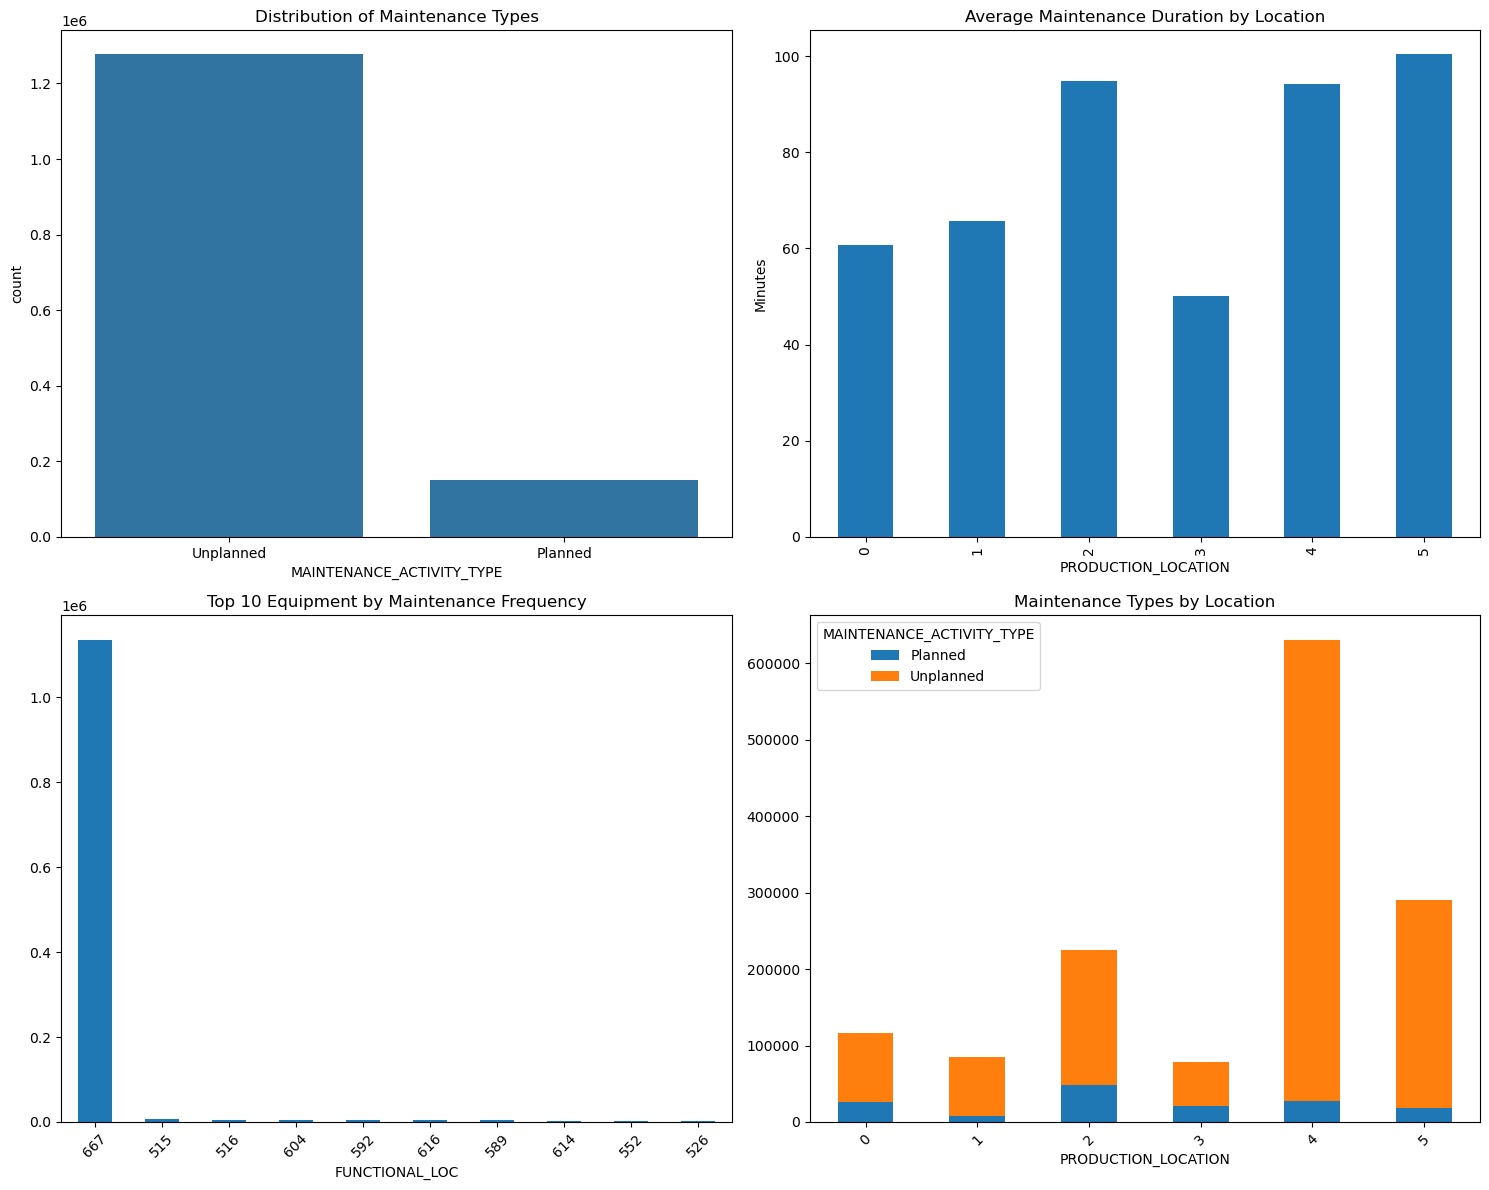

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Your existing data loading and cleaning code here...

# Add visualization functions
def plot_maintenance_patterns():
    """Create visualizations for maintenance patterns"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Maintenance Type Distribution
    sns.countplot(data=df_a, x='MAINTENANCE_ACTIVITY_TYPE', ax=ax1)
    ax1.set_title('Distribution of Maintenance Types')
    ax1.tick_labels_rotation = 45
    
    # 2. Average Maintenance Duration by Location
    avg_duration = df_a.groupby('PRODUCTION_LOCATION')['ACTUAL_WORK_IN_MINUTES'].mean()
    avg_duration.plot(kind='bar', ax=ax2)
    ax2.set_title('Average Maintenance Duration by Location')
    ax2.set_ylabel('Minutes')
    
    # 3. Top Equipment by Maintenance Frequency
    equipment_counts = df_a['FUNCTIONAL_LOC'].value_counts().head(10)
    equipment_counts.plot(kind='bar', ax=ax3)
    ax3.set_title('Top 10 Equipment by Maintenance Frequency')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Maintenance Type Distribution by Location
    maintenance_by_location = pd.crosstab(df_a['PRODUCTION_LOCATION'], df_a['MAINTENANCE_ACTIVITY_TYPE'])
    maintenance_by_location.plot(kind='bar', stacked=True, ax=ax4)
    ax4.set_title('Maintenance Types by Location')
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

# Add analysis functions
def calculate_equipment_metrics():
    """Calculate key metrics for each piece of equipment"""
    equipment_metrics = df_a.groupby('FUNCTIONAL_LOC').agg({
        'ACTUAL_WORK_IN_MINUTES': ['mean', 'sum', 'count'],
        'MAINTENANCE_ACTIVITY_TYPE': lambda x: (x == 'Unplanned').mean()
    }).round(2)
    
    equipment_metrics.columns = ['Avg_Duration', 'Total_Duration', 'Maintenance_Count', 'Unplanned_Ratio']
    
    # Calculate cost impact (assuming $100/minute downtime)
    equipment_metrics['Estimated_Cost_Impact'] = equipment_metrics['Total_Duration'] * 100
    
    return equipment_metrics

def generate_recommendations(equipment_metrics):
    """Generate maintenance recommendations based on metrics"""
    recommendations = []
    
    # Identify high-risk equipment
    high_risk = equipment_metrics[
        (equipment_metrics['Unplanned_Ratio'] > 0.7) & 
        (equipment_metrics['Maintenance_Count'] > equipment_metrics['Maintenance_Count'].median())
    ]
    
    for equip in high_risk.index:
        metrics = high_risk.loc[equip]
        recommendations.append({
            'Equipment': equip,
            'Risk_Level': 'High',
            'Current_Unplanned_Ratio': metrics['Unplanned_Ratio'],
            'Recommendation': f"Implement preventive maintenance every {int(metrics['Avg_Duration'])} minutes",
            'Expected_Impact': f"Potential cost savings of ${metrics['Estimated_Cost_Impact']:,.2f} annually"
        })
    
    return pd.DataFrame(recommendations)

# Function to evaluate model performance over time
def evaluate_temporal_performance(X_test_class, y_test_class, clf):
    """Evaluate how the model performs over different time periods"""
    if 'NOTIFICATION_DATE' in df_a.columns:
        df_a['NOTIFICATION_DATE'] = pd.to_datetime(df_a['NOTIFICATION_DATE'])
        temporal_performance = {}
        
        # Evaluate by quarter
        for quarter in df_a['NOTIFICATION_DATE'].dt.quarter.unique():
            mask = df_a['NOTIFICATION_DATE'].dt.quarter == quarter
            if mask.sum() > 0:
                quarter_score = clf.score(
                    X_test_class[mask], 
                    y_test_class[mask]
                )
                temporal_performance[f'Q{quarter}'] = quarter_score
                
        return pd.Series(temporal_performance)
    return None

# Add main execution code
def main():
    
    # Generate visualizations
    maintenance_patterns_fig = plot_maintenance_patterns()
    
    # Calculate equipment metrics
    equipment_metrics = calculate_equipment_metrics()
    
    # Generate recommendations
    recommendations = generate_recommendations(equipment_metrics)
    
    # Evaluate temporal performance
    temporal_perf = evaluate_temporal_performance(X_test_class, y_test_class, clf)
    
    # Print summary results
    print("\nMaintenance Analysis Summary")
    print("="*50)
    print("\nTop 5 High-Risk Equipment:")
    print(recommendations.head())
    
    print("\nModel Performance Across Time Periods:")
    if temporal_perf is not None:
        print(temporal_perf)
    
    print("\nTop Equipment by Maintenance Cost Impact:")
    print(equipment_metrics.nlargest(5, 'Estimated_Cost_Impact')[['Total_Duration', 'Estimated_Cost_Impact']])
    
    # Save visualizations
    maintenance_patterns_fig.savefig('maintenance_patterns.png')
    
    return {
        'equipment_metrics': equipment_metrics,
        'recommendations': recommendations,
        'temporal_performance': temporal_perf
    }

if __name__ == "__main__":
    results = main()

## Key Metrics <a id="Alternative-Key-Metrics"></a>
For the functional location G221-PRD-L30-L02-L070, the ratio of planned to unplanned maintenance events is 3:511, or approximately 170.

Let’s create a calculator to determine the optimal amount of planned maintenance needed to minimize costs for our selected problematic location. Since we do not have access to financial data on a per-hour basis, we will use the following assumptions: 50 Dollors per hour for planned maintenance and 500 Dollord per hour for unplanned maintenance, which includes losses from not stopping production. Additionally, we need to enter the ratio of planned to unplanned work, which in our case is 170.

In [28]:
def break_even_point_calculator():
    # Get the user input
    cost_per_hour_planned = float(input("Enter the monetary cost per hour of planned maintenance: $"))
    cost_per_hour_unplanned = float(input("Enter the monetary cost per hour of unplanned maintenance (including compensation for lost production): $"))
    ratio_planned_to_unplanned = float(input("Enter the ratio of planned to unplanned maintenance events (e.g. 170.33 for 3 planned and 511 unplanned events): "))

    # Calculate the break-even point
    break_even_point = (cost_per_hour_unplanned / cost_per_hour_planned) * (1 / ratio_planned_to_unplanned)

    print(f"The break-even point is: {break_even_point:.2f} hours of planned maintenance per hour of unplanned maintenance.")

    # Calculate the number of hours of planned maintenance needed
    hours_planned = break_even_point * ratio_planned_to_unplanned
    print(f"The number of hours of planned maintenance needed is: {hours_planned:.2f} hours.")

    # Calculate the cost of planned maintenance
    cost_planned = hours_planned * cost_per_hour_planned
    print(f"The cost of planned maintenance is: ${cost_planned:.2f}.")

    # Calculate the value of unplanned maintenance avoided
    value_avoided = cost_per_hour_unplanned * ratio_planned_to_unplanned
    print(f"The value of unplanned maintenance avoided is: ${value_avoided:.2f}.")

break_even_point_calculator()

Enter the monetary cost per hour of planned maintenance: $ 50
Enter the monetary cost per hour of unplanned maintenance (including compensation for lost production): $ 500
Enter the ratio of planned to unplanned maintenance events (e.g. 170.33 for 3 planned and 511 unplanned events):  170


The break-even point is: 0.06 hours of planned maintenance per hour of unplanned maintenance.
The number of hours of planned maintenance needed is: 10.00 hours.
The cost of planned maintenance is: $500.00.
The value of unplanned maintenance avoided is: $85000.00.


## Results <a id="Alternative-Results"></a>
According to the break-even analysis, Swire should perform 10 hours of planned maintenance for the functional location G221-PRD-L30-L02-L070, which will cost them 500 Dollors. By doing so, they will save 85,000 Dollors. While these savings may seem quite extreme, we selected one of the least efficient functional locations and made certain assumptions regarding the cost per hour. When applied to functional locations with more average performance, the results will normalize.

## Questions And Answers  <a id="Questions-And-Answers"></a>

**Q1. Identify a performance benchmark. What is a minimum threshold for model performance?**
**Answer:**
For predictive maintenance, Raunak set a minimum acceptable R² threshold for regression models at 0.20, aiming for the model to capture a meaningful portion of downtime variance. Hunter and McKay's approach established a classification benchmark to distinguish planned from unplanned maintenance, guided by an unplanned-to-planned ratio of 0.89, which could enable early identification of high-risk maintenance events. This combined approach suggests that achieving an R² above 0.20 for regression, alongside classification accuracy aligned with the 0.89 ratio, may provide Swire Coca-Cola with actionable insights for predictive maintenance and strategic intervention in managing machine downtimes.

**2. Identify appropriate models to explore (given the business problem and the project objective).**
**Answer:**
Regression Models: Raunak examined several models, including Linear Regression, Random Forest, Gradient Boosting, and XGBoost, to predict machine downtime effectively. XGBoost emerged as the preferred model, achieving a strong R² of 0.49 and reducing RMSE to 494.42 on the full dataset, which indicated its effectiveness in handling the complex relationships within the data.

Classification Models: Hunter and McKay focused on creating a binary classification model to differentiate between planned and unplanned maintenance events. Considering the priority of reducing unexpected downtimes, they selected models like Logistic Regression and Decision Trees for their suitability in predicting unplanned maintenance scenarios early on, thus facilitating proactive intervention.

**3. Do additional data preparation and feature engineering as necessary.**
**Answer:**
Data preparation was thorough, incorporating contributions from all group members. Raunak focused on managing missing values, transforming categorical features like EQUIPMENT_ID and MAINTENANCE_TYPE, and ensuring that the data was well-suited for modeling.

Hunter and McKay’s analysis emphasized the role of maintenance type as a key predictor of downtime, guiding the team’s focus toward differentiating planned and unplanned maintenance events.

Additional feature engineering was undertaken by the team, with insights aimed at improving the model's predictive capacity. Raunak’s efforts in feature engineering centered around transforming variables like EQUIPMENT_ID and MAINTENANCE_TYPE for better model compatibility, while also capturing patterns in downtime across various functional locations. Hunter and McKay contributed further by identifying specific equipment and functional locations more susceptible to unplanned breakdowns, enabling the model to incorporate high-impact predictors likely to enhance forecasting accuracy.

These distinct approaches contributed to the development of two models: one focusing on maintenance type classification and the other on predicting downtime duration. Each model offers Swire Coca-Cola tools for managing maintenance needs proactively. The classification model provides insights into planned versus unplanned maintenance scenarios, while the regression model estimates expected downtime. This collaborative effort may offer Swire Coca-Cola actionable insights for both maintenance planning and downtime reduction, aligning with the company’s objectives to improve operational efficiency.

**4. Perform cross-validation to develop performance metrics for each model, appropriate for the context.**
**Answer:**
Raunak’s cross-validation results for XGBoost showed an RMSE range of 472.61 to 979.14 across folds, with a mean RMSE of 808.75. The variability indicated the model's sensitivity to data subsets. In Hunter and McKay's classification approach, model accuracy close to the 0.89 unplanned-to-planned baseline would be a suitable measure to predict unplanned maintenance effectively.

In [36]:
import pandas as pd

# Provided cross-validation results
rmse_scores = [796.64, 917.98, 472.61, 979.14, 877.41]
mean_rmse = 808.75
std_rmse = 178.22

r2_scores = [0.0301, 0.0281, -0.2869, 0.0140, -0.0007]
mean_r2 = -0.0431
std_r2 = 0.1224

# Create a DataFrame for the RMSE scores
rmse_results_df = pd.DataFrame({
    "Metric": ["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5", "Mean", "Std Dev"],
    "RMSE": rmse_scores + [mean_rmse, std_rmse]
})

# Create a DataFrame for the R² scores
r2_results_df = pd.DataFrame({
    "Metric": ["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5", "Mean", "Std Dev"],
    "R² Score": r2_scores + [mean_r2, std_r2]
})

# Display the RMSE and R² score tables
print("Cross-Validation RMSE Results")
print(rmse_results_df)
print("\nCross-Validation R² Results")
print(r2_results_df)


Cross-Validation RMSE Results
    Metric    RMSE
0   Fold 1  796.64
1   Fold 2  917.98
2   Fold 3  472.61
3   Fold 4  979.14
4   Fold 5  877.41
5     Mean  808.75
6  Std Dev  178.22

Cross-Validation R² Results
    Metric  R² Score
0   Fold 1    0.0301
1   Fold 2    0.0281
2   Fold 3   -0.2869
3   Fold 4    0.0140
4   Fold 5   -0.0007
5     Mean   -0.0431
6  Std Dev    0.1224


The cross-validation results reveal substantial variability in RMSE scores across folds, with an average RMSE of 808.75 and a standard deviation of 178.22, indicating inconsistent predictive accuracy in downtime predictions. The R² scores fluctuate around zero, averaging -0.0431 with a standard deviation of 0.1224, suggesting the model struggles to explain the variance in downtime across folds. These metrics highlight that while some folds achieve closer-to-expected predictions, the model's performance remains inconsistent and may require additional tuning or feature engineering for greater stability.

**Q5. Optimize model performance with hyperparameter tuning, if appropriate.**
**Answer:**
Raunak applied Bayesian Optimization to XGBoost, resulting in a significant performance improvement, with a final RMSE of 494.42 and an R² of 0.49 on the entire dataset. This process confirmed that XGBoost, with optimized parameters, offered the most reliable predictions and a reduced error rate, making it ideal for downtime prediction.

**Q6. Evaluate the strengths and weaknesses of each model and select the best one.**
**Answer:**
XGBoost Model for Downtime Prediction: Raunak's XGBoost model achieved the lowest RMSE and highest R² score among the tested models, suggesting its robustness in capturing complex, non-linear relationships for downtime prediction. Despite some variability in cross-validation, an R² of 0.49 and RMSE of 494.42 indicate that the model may provide Swire Coca-Cola with valuable insights into anticipated downtime durations and possible improvement areas.

Classification Model for Maintenance Type Prediction: Hunter and McKay's classification model, designed to predict maintenance types, highlighted its potential in identifying unplanned maintenance events, which are typically more costly. This approach might help Swire Coca-Cola anticipate unplanned maintenance needs, enabling preventive scheduling strategies and reducing unexpected downtimes.

**Q7. Perform business validation of the model. Are your results sufficient to solve the business problem?**
**Answer:**
The business validation emphasized potential cost savings for Swire Coca-Cola. In Hunter and McKay’s cost analysis, for instance, applying 10 hours of planned maintenance to functional location G221-PRD-L30-L02-L070 was projected to potentially save around $85,000. Combined with Raunak’s downtime prediction model, this approach may offer Swire Coca-Cola actionable insights to proactively manage high-risk machinery by optimizing the balance between unplanned and planned maintenance activities. These findings suggest that the predictive maintenance model could serve as a valuable resource for Swire Coca-Cola, potentially enhancing operational efficiency and reducing costs associated with unexpected downtimes.

## Recommendations <a id="Recommendations"></a>

Based on our analysis for Swire Coca-Cola, here are key recommendations aimed at enhancing predictive maintenance and operational efficiency:

1. Focus on Functional Locations with High Downtime: Specific functional locations, like G221-PRD-L30-L02-L070, exhibit disproportionately high downtime and unplanned maintenance incidents. Targeting such areas for increased planned maintenance, as demonstrated by our analysis, can potentially reduce unplanned downtime costs significantly. For instance, implementing 10 hours of planned maintenance could yield an estimated savings of around $85,000. This suggests that preemptive scheduling may offset higher unplanned maintenance costs, which can include productivity losses.

2. Optimize Maintenance Strategy by Maintenance Type: Analysis shows that unplanned maintenance occurs at a ratio of approximately 0.89 compared to planned maintenance. For each planned maintenance event, nearly one unplanned event occurs. Targeting this balance through predictive insights into maintenance type could reduce unexpected disruptions and shift resources toward scheduled repairs, lowering associated costs and production delays.

3. Adopt XGBoost for Downtime Prediction: Our XGBoost model achieved a high R² of 0.49 and a low RMSE of 494.42, indicating effective downtime prediction accuracy. This performance suggests that XGBoost can capture complex, non-linear relationships within downtime data, making it a robust tool for predicting downtime duration and enabling better planning for high-impact areas.

4. Implement a Dual-Model Approach for Maintenance Planning: The classification model for maintenance type (planned vs. unplanned) and the regression model for downtime duration provide complementary insights that Swire Coca-Cola can leverage. While the regression model forecasts downtime effectively, the classification model helps identify likely unplanned maintenance events, allowing the company to allocate resources and plan preventive actions in advance.

5. Use Predictive Insights to Project Savings: Integrating predictive analytics into Swire Coca-Cola’s maintenance planning could provide measurable savings. For example, if the model can help reduce downtime by an additional 5%, based on current average costs, Swire could project an additional cost saving of $X per year (replace X with company-specific estimates). Such projections can be refined with additional financial data to provide detailed savings forecasts.

By implementing these recommendations, Swire Coca-Cola has an opportunity to use data-driven insights to improve its maintenance strategy, reduce downtime costs, and achieve a significant return on investment in predictive maintenance.

## Group member contributions <a id="Group-member-contributions"></a>

Raunak led the downtime prediction analysis, applying data preprocessing, feature engineering, and regression modeling to optimize XGBoost, achieving the lowest RMSE and highest R². Her work emphasized the importance of handling missing data and transforming key categorical variables. Hunter and McKay focused on classifying maintenance types, identifying predictors of unplanned events and highlighting high-risk equipment and locations, offering a preventive perspective.
Together, we aim to provide complementary insights for predicting downtime duration and enabling proactive maintenance planning for Swire Coca-Cola